In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import joblib

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import time
%matplotlib notebook

In [3]:
def generate_visualization(dataset_X, dataset_y,
                          hyper_par_ranges, resolution=20,
                          comb=1,
                          dataset_type="class"):
    
    #Checks that inputs are correct
    possible_combs = [1, 2, 3, 4, 5, 6]
    
    if (comb not in possible_combs):
        print("Specified combination number is not supported by the algorithm.")
        return
    
    #splits dataset
    dataset_X_1 = dataset_X.iloc[:(round(len(dataset_X)*0.5))]
    dataset_y_1 = dataset_y.iloc[:(round(len(dataset_y)*0.5))]
    dataset_X_2 = dataset_X.iloc[(round(len(dataset_X)*0.5)):]
    dataset_y_2 = dataset_y.iloc[(round(len(dataset_y)*0.5)):]
    
    learning_rate_range, n_estimators_range, max_depth_range, reg_lamda_range = hyper_par_ranges
    
    H = pd.DataFrame()
    H["learning_rate"] = learning_rate_range
    H["n_estimators"] = n_estimators_range
    H["max_depth"] = max_depth_range
    H["reg_lamda"] = reg_lamda_range
    
    accuracy = -np.ones((resolution,resolution))
    mae = -np.ones((resolution,resolution))

    for x in range(resolution):
        for y in range(resolution):
            
            if dataset_type == "class":
                if comb == 1:
                    alg = XGBClassifier(learning_rate=H["learning_rate"][x], n_estimators=H["n_estimators"][y])
                elif comb == 2:
                    alg = XGBClassifier(learning_rate=H["learning_rate"][x], max_depth=H["max_depth"][y])
                elif comb == 3:
                    alg = XGBClassifier(learning_rate=H["learning_rate"][x], reg_lamda=H["reg_lamda"][y])
                elif comb == 4:
                    alg = XGBClassifier(n_estimators=H["n_estimators"][x], max_depth=H["max_depth"][y])
                elif comb == 5:
                    alg = XGBClassifier(n_estimators=H["n_estimators"][x], reg_lamda=H["reg_lamda"][y])
                elif comb == 6:
                    alg = XGBClassifier(max_depth=H["max_depth"][x], reg_lamda=H["reg_lamda"][y])
            else:
                if comb == 1:
                    alg = XGBRegressor(learning_rate=H["learning_rate"][x], n_estimators=H["n_estimators"][y])
                elif comb == 2:
                    alg = XGBRegressor(learning_rate=H["learning_rate"][x], max_depth=H["max_depth"][y])
                elif comb == 3:
                    alg = XGBRegressor(learning_rate=H["learning_rate"][x], reg_lamda=H["reg_lamda"][y])
                elif comb == 4:
                    alg = XGBRegressor(n_estimators=H["n_estimators"][x], max_depth=H["max_depth"][y])
                elif comb == 5:
                    alg = XGBRegressor(n_estimators=H["n_estimators"][x], reg_lamda=H["reg_lamda"][y])
                elif comb == 6:
                    alg = XGBRegressor(max_depth=H["max_depth"][x], reg_lamda=H["reg_lamda"][y])
            
            trained_alg_1 = alg.fit(dataset_X_1, dataset_y_1)
            trained_alg_2 = alg.fit(dataset_X_2, dataset_y_2)

            pred_1 = trained_alg_1.predict(dataset_X_2)
            pred_2 = trained_alg_2.predict(dataset_X_1)

            if dataset_type == "class":
                accuracy_1 = metrics.accuracy_score(dataset_y_2, pred_1)
                accuracy_2 = metrics.accuracy_score(dataset_y_1, pred_2)
                
                accuracy[y, x] = (accuracy_1 + accuracy_2)/2
            else:
                mae_1 = metrics.mean_absolute_error(dataset_y_2, pred_1)
                mae_2 = metrics.mean_absolute_error(dataset_y_1, pred_2)
            
                mae[y, x] = (mae_1 + mae_2)/2
                
    if dataset_type == "class":
        return accuracy
    else:
        return mae


In [4]:
def visualize(surface, meshes, comb=1, dataset_type="class"):
    
    #Checks input
    possible_combs = [1, 2, 3, 4, 5, 6]
    if (comb not in possible_combs):
        print("Specified combination number is not supported by the algorithm.")
        return
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    if dataset_type == "class":
        ax.set_zlabel("Accuracy")
    else:
        ax.set_zlabel("MAE")
        
    comb1_mesh, comb2_mesh, comb3_mesh, comb4_mesh, comb5_mesh, comb6_mesh = meshes
    
    if comb == 1:
        ax.set_xlabel("learning_rate")
        ax.set_ylabel("n_estimators")
        m1, m2 = comb1_mesh
    elif comb == 2:
        ax.set_xlabel("learning_rate")
        ax.set_ylabel("max_depth")
        m1, m2 = comb2_mesh
    elif comb == 3:
        ax.set_xlabel("learning_rate")
        ax.set_ylabel("reg_lamda")
        m1, m2 = comb3_mesh
    elif comb == 4:
        ax.set_xlabel("n_estimators")
        ax.set_ylabel("max_depth")
        m1, m2 = comb4_mesh
    elif comb == 5:
        ax.set_xlabel("n_estimators")
        ax.set_ylabel("reg_lamda")
        m1, m2 = comb5_mesh
    elif comb == 6:
        ax.set_xlabel("max_depth")
        ax.set_ylabel("reg_lamda")
        m1, m2 = comb6_mesh
        
    ax.plot_surface(m1, m2, surface, cmap=cm.RdYlBu,
                       linewidth=0, antialiased=False)

In [5]:
def generate_meshgrids(ranges):
    
    learning_rate_range, n_estimators_range, max_depth_range, reg_lamda_range = ranges
    
    comb1_m1, comb1_m2 = np.meshgrid(learning_rate_range, n_estimators_range)
    comb2_m1, comb2_m2 = np.meshgrid(learning_rate_range, max_depth_range)
    comb3_m1, comb3_m2 = np.meshgrid(learning_rate_range, reg_lamda_range)
    comb4_m1, comb4_m2 = np.meshgrid(n_estimators_range, max_depth_range)
    comb5_m1, comb5_m2 = np.meshgrid(n_estimators_range, reg_lamda_range)
    comb6_m1, comb6_m2 = np.meshgrid(max_depth_range, reg_lamda_range)
    
    comb1_meshes = (comb1_m1, comb1_m2)
    comb2_meshes = (comb2_m1, comb2_m2)
    comb3_meshes = (comb3_m1, comb3_m2)
    comb4_meshes = (comb4_m1, comb4_m2)
    comb5_meshes = (comb5_m1, comb5_m2)
    comb6_meshes = (comb6_m1, comb6_m2)
    
    meshes = (comb1_meshes, comb2_meshes, comb3_meshes, comb4_meshes, comb5_meshes, comb6_meshes)
    
    return meshes

In [6]:
def comb_mesh(meshes, comb=1):
    
    comb1_mesh, comb2_mesh, comb3_mesh, comb4_mesh, comb5_mesh, comb6_mesh = meshes
    
    if comb == 1:
        return comb1_mesh
    elif comb == 2:
        return comb2_mesh
    elif comb == 3:
        return comb3_mesh
    elif comb == 4:
        return comb4_mesh
    elif comb == 5:
        return comb5_mesh
    elif comb == 6:
        return comb5_mesh

In [7]:
def zoom(surface, mesh_1, mesh_2, percentage=0.5, resolution=50, htype1="float", htype2="float", sort_dir="asc"):
    values = surface.ravel()
    coord_1 = mesh_1.ravel()
    coord_2 = mesh_2.ravel()
    
    points = np.array([values, coord_1, coord_2])
    points = points.transpose()
    
    if sort_dir == "asc":
        sorted_points = points[points[:,0].argsort()]
    else:
        sorted_points = points[points[:,0].argsort()[::-1]]
    
    best_values = sorted_points[:round(len(sorted_points)*percentage)]
    
    coord_1_min = best_values[:,1].min()
    coord_1_max = best_values[:,1].max()
    
    coord_2_min = best_values[:,2].min()
    coord_2_max = best_values[:,2].max()
    
    if htype1 == "float":
        new_range_1 = np.linspace(coord_1_min, coord_1_max, resolution)
    else:
        new_range_1 = np.linspace(coord_1_min, coord_1_max, resolution, dtype=int)
        
    if htype2 == "float":
        new_range_2 = np.linspace(coord_2_min, coord_2_max, resolution)
    else:
        new_range_2 = np.linspace(coord_2_min, coord_2_max, resolution, dtype=int)
        
    new_mesh_1, new_mesh_2 = np.meshgrid(new_range_1, new_range_2)
    
    return (new_range_1, new_range_2, new_mesh_1, new_mesh_2)

In [8]:
def ranges_for_zoom(l1, l2, comb=1, resolution=50):
    
    learning_rate = np.linspace(0.0,2.0,resolution)
    n_estimators = np.linspace(1,500,resolution, dtype=int)
    max_depth = np.linspace(1,29,resolution, dtype=int)
    reg_lamda = np.linspace(0.0, 2.0, resolution)
    
    if comb == 1:
        learning_rate = l1
        n_estimators = l2
    elif comb == 2:
        learning_rate = l1
        max_depth = l2
    elif comb == 3:
        learning_rate = l1
        reg_lamda = l2
    elif comb == 4:
        n_estimators = l1
        max_depth = l2
    elif comb == 5:
        n_estimators = l1
        reg_lamda = l2
    elif comb == 6:
        max_depth = l1
        reg_lamda = l2
    else:
        print("Combination does not exist.")
        
    return (learning_rate, n_estimators, max_depth, reg_lamda)

In [9]:
def generate_zoom(X, y, from_file, from_meshes, save_path, 
                  zoom1=True, save=True, comb=1, resolution=50, percentage=0.5, 
                  dataset_type="class", print_ranges=False):
    
    m1, m2 = comb_mesh(from_meshes, comb=comb)
    
    if zoom1 == True:
        file = np.load(from_file)
    else:
        file, file_meshes = np.load(from_file, allow_pickle=True)
    
    if comb == 1 or comb == 2:
        h1 = "float"
        h2 = "int"
    elif comb == 3:
        h1 = "float"
        h2 = "float"
    elif comb == 4:
        h1 = "int"
        h2 = "int"
    elif comb == 5 or comb == 6:
        h1 = "int"
        h2 = "float"
    
    if dataset_type == "class":
        zoom_pack = zoom(file, m1, m2, percentage=percentage, htype1=h1, htype2=h2, sort_dir="desc")
    else:
        zoom_pack = zoom(file, m1, m2, percentage=percentage, htype1=h1, htype2=h2, sort_dir="asc")
        
    new_lin1, new_lin2, new_m1, new_m2 = zoom_pack
        
    if print_ranges == True:
        print((new_lin1,new_lin2))
        return
    
    zoom_ranges = ranges_for_zoom(new_lin1, new_lin2, comb=comb, resolution=resolution)
    
    zoom_meshes = generate_meshgrids(zoom_ranges)
    
    zoom_surface = generate_visualization(X, y, zoom_ranges, resolution=resolution, comb=comb, dataset_type=dataset_type)
    
    if save == True:
        save_tuple = (zoom_surface, zoom_meshes)
        np.save(save_path, save_tuple)
        
    return (zoom_surface, zoom_meshes)

# Forestfires

In [10]:
forestfires = pd.read_csv("forestfires_pp.csv")
forestfires_X = forestfires.drop(["area"], axis=1)
forestfires_y = forestfires["area"]

In [11]:
forestfires_learning_rate = np.linspace(0.0,2.0,20)
forestfires_n_estimators = np.linspace(1,500,20, dtype=int)
forestfires_max_depth = np.linspace(1,29,20, dtype=int)
forestfires_reg_lamda = np.linspace(0.0, 2.0, 20)

forestfires_ranges = (forestfires_learning_rate, forestfires_n_estimators, forestfires_max_depth, forestfires_reg_lamda)

In [12]:
forestfires_meshes = generate_meshgrids(forestfires_ranges)

## Forestfires Comb 1

In [25]:
forestfires_comb1 = generate_visualization(forestfires_X, forestfires_y, forestfires_ranges, 
                                           resolution=20, comb=1, dataset_type="reg")

In [51]:
#np.save(".\\np_arrays\\forestfires_comb1.npy", forestfires_comb1)

In [16]:
forestfires_comb1 = np.load(".\\np_arrays\\forestfires_comb1.npy")

In [49]:
forestfires_comb1 = 0-forestfires_comb1

<IPython.core.display.Javascript object>


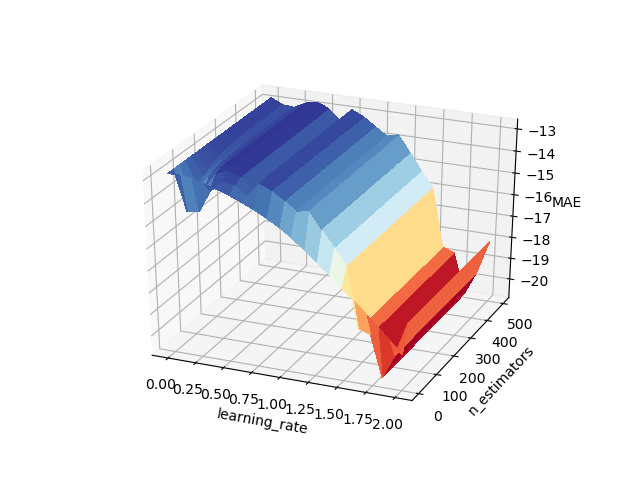

In [50]:
visualize(forestfires_comb1, forestfires_meshes, comb=1, dataset_type="reg")

### Forestfires Comb 1 - Zoom 1

In [33]:
forestfires_comb1_m1, forestfires_comb1_m2 = comb_mesh(forestfires_meshes, comb=1)

In [34]:
forestfires_comb1 = np.load(".\\np_arrays\\forestfires_comb1.npy")
#surface, mesh_1, mesh_2, percentage=0.5, htype1="float", htype2="float", sort_dir="asc"
forestfires_comb1_zoom1_pack = zoom(forestfires_comb1, forestfires_comb1_m1, forestfires_comb1_m2,
                                   percentage=0.5, htype1="float", htype2="int", sort_dir="asc")

In [35]:
forestfires_comb1_zoom1_lin1, forestfires_comb1_zoom1_lin2, forestfires_comb1_zoom1_m1, forestfires_comb1_zoom1_m2 = forestfires_comb1_zoom1_pack

In [14]:
forestfires_comb1_zoom1_lin1, forestfires_comb1_zoom1_lin2

(array([0.        , 0.0236305 , 0.04726101, 0.07089151, 0.09452202,
        0.11815252, 0.14178303, 0.16541353, 0.18904404, 0.21267454,
        0.23630505, 0.25993555, 0.28356606, 0.30719656, 0.33082707,
        0.35445757, 0.37808808, 0.40171858, 0.42534909, 0.44897959,
        0.4726101 , 0.4962406 , 0.51987111, 0.54350161, 0.56713212,
        0.59076262, 0.61439313, 0.63802363, 0.66165414, 0.68528464,
        0.70891515, 0.73254565, 0.75617615, 0.77980666, 0.80343716,
        0.82706767, 0.85069817, 0.87432868, 0.89795918, 0.92158969,
        0.94522019, 0.9688507 , 0.9924812 , 1.01611171, 1.03974221,
        1.06337272, 1.08700322, 1.11063373, 1.13426423, 1.15789474]),
 array([  1,  11,  21,  31,  41,  51,  62,  72,  82,  92, 102, 113, 123,
        133, 143, 153, 163, 174, 184, 194, 204, 214, 225, 235, 245, 255,
        265, 275, 286, 296, 306, 316, 326, 337, 347, 357, 367, 377, 387,
        398, 408, 418, 428, 438, 449, 459, 469, 479, 489, 500]))

In [36]:
forestfires_comb1_zoom1_ranges = ranges_for_zoom(forestfires_comb1_zoom1_lin1, forestfires_comb1_zoom1_lin2, comb=1, 
                                                 resolution=50)

In [28]:
import time
start = time.time()
forestfires_comb1_zoom1 = generate_visualization(forestfires_X, forestfires_y, forestfires_comb1_zoom1_ranges,
                                                resolution=50, comb=1, dataset_type="reg")
end = time.time()
dur = end - start
dur

294.80511593818665

In [29]:
#np.save("./np_arrays_50/forestfires_comb1_zoom1.npy", forestfires_comb1_zoom1)

In [37]:
forestfires_comb1_zoom1 = np.load("./np_arrays_50/forestfires_comb1_zoom1.npy")

In [38]:
forestfires_comb1_zoom1_meshes = generate_meshgrids(forestfires_comb1_zoom1_ranges)

In [40]:
forestfires_comb1_zoom1 = 0 - forestfires_comb1_zoom1

<IPython.core.display.Javascript object>


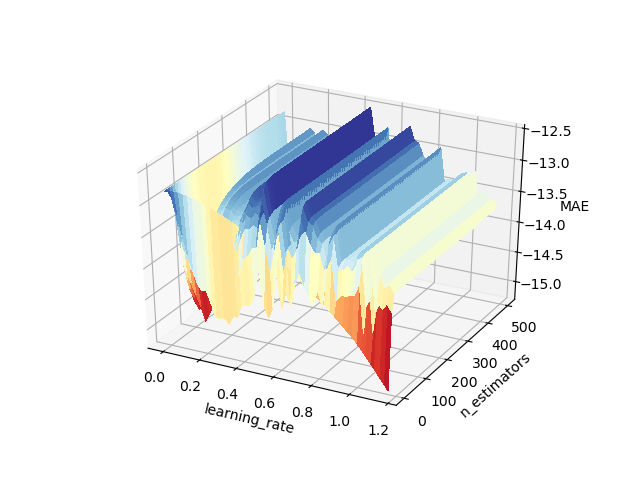

In [43]:
visualize(forestfires_comb1_zoom1, forestfires_comb1_zoom1_meshes, comb=1, dataset_type="reg")

### Forestfires Comb 1 - Zoom 2

In [36]:
forestfires_comb1_zoom1 = np.load(".\\np_arrays_50\\forestfires_comb1_zoom1.npy")
forestfires_comb1_zoom2_pack = zoom(forestfires_comb1_zoom1, forestfires_comb1_zoom1_m1, forestfires_comb1_zoom1_m2,
                                   percentage=0.5, htype1="float", htype2="int", sort_dir="asc")

In [37]:
#forestfires_comb1_zoom1_lin1, forestfires_comb1_zoom1_lin2, forestfires_comb1_zoom1_m1, forestfires_comb1_zoom1_m2 = forestfires_comb1_zoom1_pack
forestfires_comb1_zoom2_lin1, forestfires_comb1_zoom2_lin2, forestfires_comb1_zoom2_m1, forestfires_comb1_zoom2_m2 = forestfires_comb1_zoom2_pack

In [38]:
forestfires_comb1_zoom2_lin1, forestfires_comb1_zoom2_lin2

(array([0.        , 0.02121923, 0.04243846, 0.06365769, 0.08487692,
        0.10609614, 0.12731537, 0.1485346 , 0.16975383, 0.19097306,
        0.21219229, 0.23341152, 0.25463075, 0.27584997, 0.2970692 ,
        0.31828843, 0.33950766, 0.36072689, 0.38194612, 0.40316535,
        0.42438458, 0.44560381, 0.46682303, 0.48804226, 0.50926149,
        0.53048072, 0.55169995, 0.57291918, 0.59413841, 0.61535764,
        0.63657686, 0.65779609, 0.67901532, 0.70023455, 0.72145378,
        0.74267301, 0.76389224, 0.78511147, 0.8063307 , 0.82754992,
        0.84876915, 0.86998838, 0.89120761, 0.91242684, 0.93364607,
        0.9548653 , 0.97608453, 0.99730376, 1.01852298, 1.03974221]),
 array([  1,  11,  21,  31,  41,  51,  62,  72,  82,  92, 102, 113, 123,
        133, 143, 153, 163, 174, 184, 194, 204, 214, 225, 235, 245, 255,
        265, 275, 286, 296, 306, 316, 326, 337, 347, 357, 367, 377, 387,
        398, 408, 418, 428, 438, 449, 459, 469, 479, 489, 500]))

In [39]:
forestfires_comb1_zoom2_ranges = ranges_for_zoom(forestfires_comb1_zoom2_lin1, forestfires_comb1_zoom2_lin2, comb=1,
                                                resolution=50)

In [41]:
start = time.time()
forestfires_comb1_zoom2 = generate_visualization(forestfires_X, forestfires_y, forestfires_comb1_zoom2_ranges,
                                                resolution=50, comb=1, dataset_type="reg")
end = time.time()
dur = (end - start)/60
dur

5.467808675765991

In [42]:
#np.save("./np_arrays_50/forestfires_comb1_zoom2.npy", forestfires_comb1_zoom2)

In [43]:
forestfires_comb1_zoom2 = np.load("./np_arrays_50/forestfires_comb1_zoom2.npy")

In [44]:
forestfires_comb1_zoom2_meshes = generate_meshgrids(forestfires_comb1_zoom2_ranges)

In [45]:
forestfires_comb1_zoom2 = 0 - forestfires_comb1_zoom2

<IPython.core.display.Javascript object>


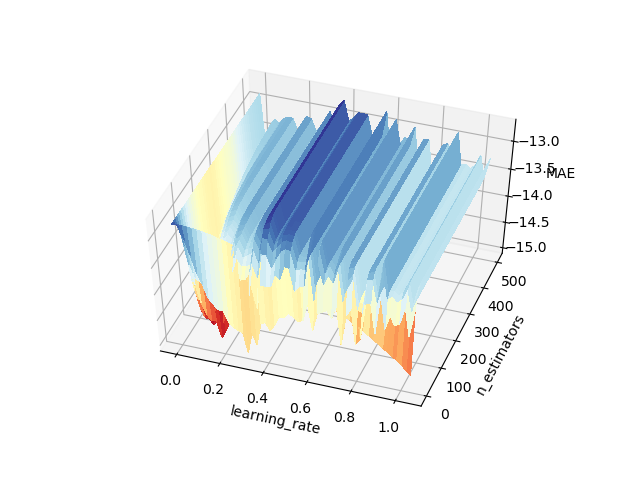

In [47]:
visualize(forestfires_comb1_zoom2, forestfires_comb1_zoom2_meshes, comb=1, dataset_type="reg")

### Forestfires Comb 1 - Zoom 3

In [51]:
forestfires_comb1_zoom2 = np.load("./np_arrays_50/forestfires_comb1_zoom2.npy")
forestfires_comb1_zoom3_pack = zoom(forestfires_comb1_zoom2, forestfires_comb1_zoom2_m1, forestfires_comb1_zoom2_m2,
                                   percentage=0.5, htype1="float", htype2="int", sort_dir="asc")

In [52]:
forestfires_comb1_zoom3_lin1, forestfires_comb1_zoom3_lin2, forestfires_comb1_zoom3_m1, forestfires_comb1_zoom3_m2 = forestfires_comb1_zoom3_pack

In [53]:
forestfires_comb1_zoom3_lin1, forestfires_comb1_zoom3_lin2

(array([0.        , 0.02035314, 0.04070628, 0.06105941, 0.08141255,
        0.10176569, 0.12211883, 0.14247197, 0.1628251 , 0.18317824,
        0.20353138, 0.22388452, 0.24423765, 0.26459079, 0.28494393,
        0.30529707, 0.32565021, 0.34600334, 0.36635648, 0.38670962,
        0.40706276, 0.4274159 , 0.44776903, 0.46812217, 0.48847531,
        0.50882845, 0.52918158, 0.54953472, 0.56988786, 0.590241  ,
        0.61059414, 0.63094727, 0.65130041, 0.67165355, 0.69200669,
        0.71235983, 0.73271296, 0.7530661 , 0.77341924, 0.79377238,
        0.81412551, 0.83447865, 0.85483179, 0.87518493, 0.89553807,
        0.9158912 , 0.93624434, 0.95659748, 0.97695062, 0.99730376]),
 array([  1,  11,  21,  31,  41,  51,  62,  72,  82,  92, 102, 113, 123,
        133, 143, 153, 163, 174, 184, 194, 204, 214, 225, 235, 245, 255,
        265, 275, 286, 296, 306, 316, 326, 337, 347, 357, 367, 377, 387,
        398, 408, 418, 428, 438, 449, 459, 469, 479, 489, 500]))

Very little difference.

## Forestfires Comb 2

In [34]:
forestfires_comb2 = generate_visualization(forestfires_X, forestfires_y, forestfires_ranges, resolution=20, comb=2, 
                                           dataset_type="reg")

In [35]:
#np.save(".\\np_arrays\\forestfires_comb2.npy", forestfires_comb2)

In [13]:
forestfires_comb2 = np.load(".\\np_arrays\\forestfires_comb2.npy")

In [14]:
forestfires_comb2 = 0-forestfires_comb2

<IPython.core.display.Javascript object>


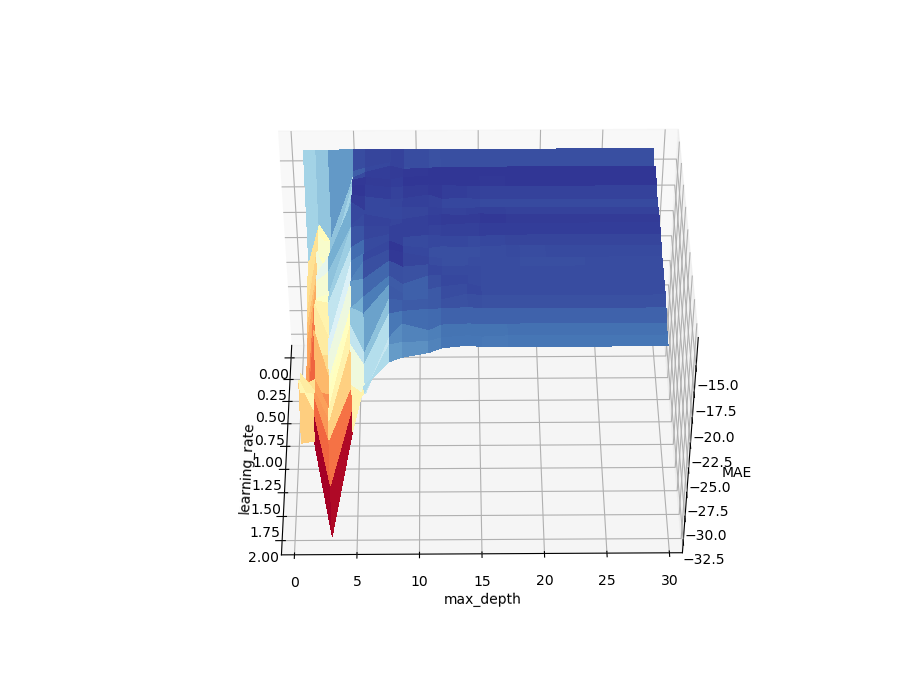

In [15]:
visualize(forestfires_comb2, forestfires_meshes, comb=2, dataset_type="reg")

### Forestfires Comb 2 - Zoom 1

In [18]:
#forestfires_comb1_m1, forestfires_comb1_m2 = comb_mesh(forestfires_meshes, comb=1)
forestfires_comb2_m1, forestfires_comb2_m2 = comb_mesh(forestfires_meshes, comb=2) 
forestfires_comb2 = np.load("./np_arrays/forestfires_comb1.npy")
forestfires_comb2_zoom1_pack = zoom(forestfires_comb2, forestfires_comb2_m1, forestfires_comb2_m2,
                                   percentage=0.5, htype1="float", htype2="int", sort_dir="asc")

In [19]:
forestfires_comb2_zoom1_lin1, forestfires_comb2_zoom1_lin2, forestfires_comb2_zoom1_m1, forestfires_comb2_zoom1_m2 = forestfires_comb2_zoom1_pack
forestfires_comb2_zoom1_lin1, forestfires_comb2_zoom1_lin2

(array([0.        , 0.0236305 , 0.04726101, 0.07089151, 0.09452202,
        0.11815252, 0.14178303, 0.16541353, 0.18904404, 0.21267454,
        0.23630505, 0.25993555, 0.28356606, 0.30719656, 0.33082707,
        0.35445757, 0.37808808, 0.40171858, 0.42534909, 0.44897959,
        0.4726101 , 0.4962406 , 0.51987111, 0.54350161, 0.56713212,
        0.59076262, 0.61439313, 0.63802363, 0.66165414, 0.68528464,
        0.70891515, 0.73254565, 0.75617615, 0.77980666, 0.80343716,
        0.82706767, 0.85069817, 0.87432868, 0.89795918, 0.92158969,
        0.94522019, 0.9688507 , 0.9924812 , 1.01611171, 1.03974221,
        1.06337272, 1.08700322, 1.11063373, 1.13426423, 1.15789474]),
 array([ 1,  1,  2,  2,  3,  3,  4,  5,  5,  6,  6,  7,  7,  8,  9,  9, 10,
        10, 11, 11, 12, 13, 13, 14, 14, 15, 15, 16, 17, 17, 18, 18, 19, 19,
        20, 21, 21, 22, 22, 23, 23, 24, 25, 25, 26, 26, 27, 27, 28, 29]))

In [20]:
'''
forestfires_comb1_zoom2_ranges = ranges_for_zoom(forestfires_comb1_zoom2_lin1, forestfires_comb1_zoom2_lin2, comb=1,
                                                resolution=50)
'''
forestfires_comb2_zoom2_ranges = ranges_for_zoom(forestfires_comb2_zoom1_lin1, forestfires_comb2_zoom1_lin2,
                                                 comb=2,
                                                resolution=50)

In [21]:
start = time.time()
forestfires_comb2_zoom1 = generate_visualization(forestfires_X, forestfires_y, forestfires_comb2_zoom2_ranges,
                                                resolution=50, comb=2, dataset_type="reg")
end = time.time()
dur = (end - start)/60
dur

3.9431313077608743

In [22]:
#np.save(".\\np_arrays_50\\forestfires_comb2_zoom1.npy", forestfires_comb2_zoom1)

In [23]:
forestfires_comb2_zoom1 = np.load(".\\np_arrays_50\\forestfires_comb2_zoom1.npy")

In [21]:
forestfires_comb2_zoom1_meshes = generate_meshgrids(forestfires_comb2_zoom2_ranges)

In [28]:
forestfires_comb2_zoom1 = 0 - forestfires_comb2_zoom1

<IPython.core.display.Javascript object>


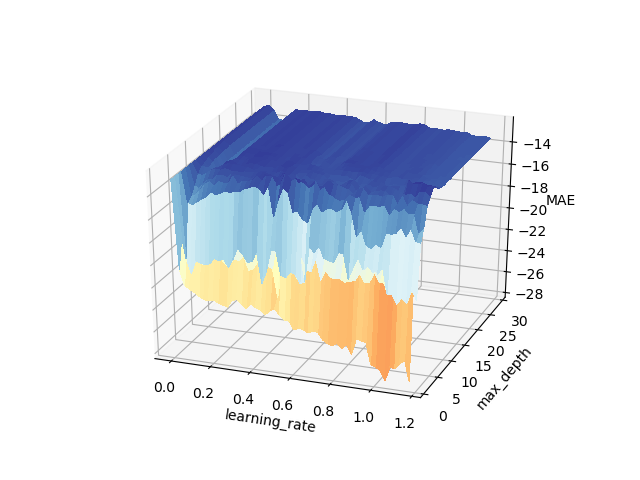

In [29]:
visualize(forestfires_comb2_zoom1, forestfires_comb2_zoom1_meshes, comb=2, dataset_type="reg")

### Forestfires Comb 2 - Zoom 2

In [44]:
'''
X, y, from_file, from_meshes, save_path, 
                  save=True, comb=1, resolution=50, percentage=0.5, 
                  dataset_type="class", print_ranges=False

test_s, test_m1, test_m2 = generate_zoom(forestfires_X, forestfires_y, "./np_arrays/forestfires_comb1.npy", forestfires_meshes,
              "evaluation.npy",
             save=True, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''
generate_zoom(forestfires_X, forestfires_y,
            "./np_arrays_50/forestfires_comb2_zoom1.npy",
            forestfires_comb2_zoom1_meshes,
            "./np_arrays_50/forestfires_comb2_zoom2.npy",
            zoom1=True, save=False, comb=2, resolution=50, percentage=0.5,
            dataset_type="reg", 
            print_ranges=True)

(array([0.        , 0.0236305 , 0.04726101, 0.07089151, 0.09452202,
       0.11815252, 0.14178303, 0.16541353, 0.18904404, 0.21267454,
       0.23630505, 0.25993555, 0.28356606, 0.30719656, 0.33082707,
       0.35445757, 0.37808808, 0.40171858, 0.42534909, 0.44897959,
       0.4726101 , 0.4962406 , 0.51987111, 0.54350161, 0.56713212,
       0.59076262, 0.61439313, 0.63802363, 0.66165414, 0.68528464,
       0.70891515, 0.73254565, 0.75617615, 0.77980666, 0.80343716,
       0.82706767, 0.85069817, 0.87432868, 0.89795918, 0.92158969,
       0.94522019, 0.9688507 , 0.9924812 , 1.01611171, 1.03974221,
       1.06337272, 1.08700322, 1.11063373, 1.13426423, 1.15789474]), array([ 1,  1,  2,  2,  3,  3,  4,  5,  5,  6,  6,  7,  7,  8,  9,  9, 10,
       10, 11, 11, 12, 13, 13, 14, 14, 15, 15, 16, 17, 17, 18, 18, 19, 19,
       20, 21, 21, 22, 22, 23, 23, 24, 25, 25, 26, 26, 27, 27, 28, 29]))


No difference.

In [ ]:
'''
forestfires_comb2_zoom2, forestfires_comb2_zoom2_meshes = generate_zoom(forestfires_X, forestfires_y,
                                                            "./np_arrays_50/forestfires_comb2_zoom1.npy",
                                                            forestfires_comb2_zoom1_meshes,
                                                            "./np_arrays_50/forestfires_comb2_zoom2.npy",
                                                            save=True, comb=2, resolution=50, percentage=0.5,
                                                            dataset_type="reg", 
                                                            print_ranges=False)
'''


In [ ]:
'''
forestfires_comb2_zoom2, forestfires_comb2_zoom2_meshes = np.load("./np_arrays_50/forestfires_comb1_zoom2.npy", 
                                                                  allow_pickle=True)
'''


In [ ]:
#visualize(forestfires_comb2_zoom2, forestfires_comb2_zoom2_meshes, comb=2, dataset_type="reg")

## Forestfires Comb 3

In [45]:
forestfires_comb3 = generate_visualization(forestfires_X, forestfires_y, forestfires_ranges, 
                                           resolution=20, comb=3, dataset_type="reg")

KeyboardInterrupt: 

In [54]:
#np.save(".\\np_arrays\\forestfires_comb3.npy", forestfires_comb3)

In [46]:
forestfires_comb3 = np.load(".\\np_arrays\\forestfires_comb3.npy")

In [66]:
forestfires_comb3 = 0 - forestfires_comb3

<IPython.core.display.Javascript object>


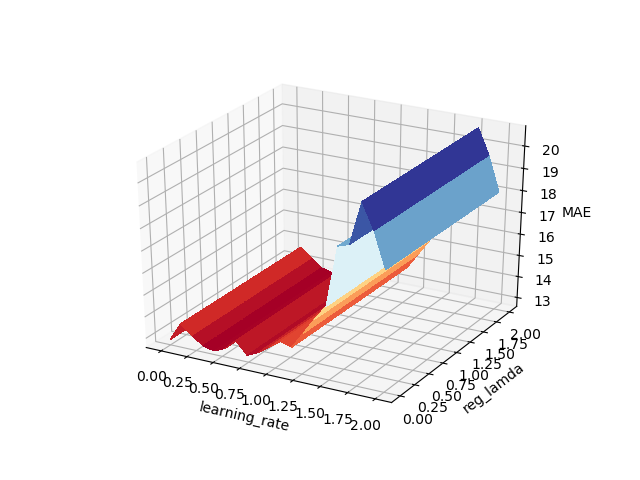

In [47]:
visualize(forestfires_comb3, forestfires_meshes, comb=3, dataset_type="reg")

### Forestfires Comb 3 - Zoom 1

In [56]:

generate_zoom(forestfires_X, forestfires_y, "./np_arrays/forestfires_comb3.npy",
             forestfires_meshes, "./np_arrays_50/forestfires_comb3_zoom1.npy",
             zoom1=True, save=False, comb=3, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.        , 0.01933405, 0.0386681 , 0.05800215, 0.0773362 ,
       0.09667025, 0.1160043 , 0.13533835, 0.1546724 , 0.17400644,
       0.19334049, 0.21267454, 0.23200859, 0.25134264, 0.27067669,
       0.29001074, 0.30934479, 0.32867884, 0.34801289, 0.36734694,
       0.38668099, 0.40601504, 0.42534909, 0.44468314, 0.46401719,
       0.48335124, 0.50268528, 0.52201933, 0.54135338, 0.56068743,
       0.58002148, 0.59935553, 0.61868958, 0.63802363, 0.65735768,
       0.67669173, 0.69602578, 0.71535983, 0.73469388, 0.75402793,
       0.77336198, 0.79269603, 0.81203008, 0.83136412, 0.85069817,
       0.87003222, 0.88936627, 0.90870032, 0.92803437, 0.94736842]), array([0.        , 0.04081633, 0.08163265, 0.12244898, 0.16326531,
       0.20408163, 0.24489796, 0.28571429, 0.32653061, 0.36734694,
       0.40816327, 0.44897959, 0.48979592, 0.53061224, 0.57142857,
       0.6122449 , 0.65306122, 0.69387755, 0.73469388, 0.7755102 ,
       0.81632653, 0.85714286, 0.89795918, 0.93877551, 0.97

In [49]:
'''
forestfires_comb3_zoom1, forestfires_comb3_zoom1_meshes =  generate_zoom(forestfires_X, forestfires_y, "./np_arrays/forestfires_comb3.npy",
                                                             forestfires_meshes, "./np_arrays_50/forestfires_comb3_zoom1.npy",
                                                             zoom1=True, save=True, comb=3, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''

In [51]:
forestfires_comb3_zoom1, forestfires_comb3_zoom1_meshes = np.load("./np_arrays_50/forestfires_comb3_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


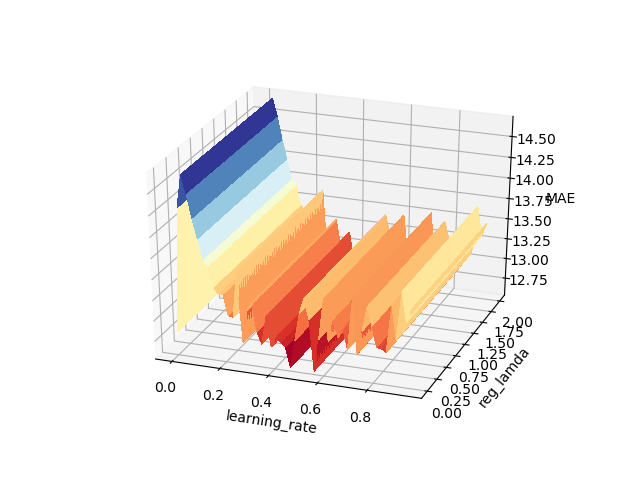

In [52]:
visualize(forestfires_comb3_zoom1, forestfires_comb3_zoom1_meshes, comb=3, dataset_type="reg")

### Forestfires Comb 3 - Zoom 2

In [58]:
forestfires_comb3_zoom1, forestfires_comb3_zoom1_meshes = np.load("./np_arrays_50/forestfires_comb3_zoom1.npy", allow_pickle=True)

generate_zoom(forestfires_X, forestfires_y, "./np_arrays_50/forestfires_comb3_zoom1.npy",
             forestfires_comb3_zoom1_meshes, "./np_arrays_50/forestfires_comb3_zoom2.npy",
             zoom1=False, save=False, comb=3, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.        , 0.01815033, 0.03630066, 0.054451  , 0.07260133,
       0.09075166, 0.10890199, 0.12705232, 0.14520266, 0.16335299,
       0.18150332, 0.19965365, 0.21780399, 0.23595432, 0.25410465,
       0.27225498, 0.29040531, 0.30855565, 0.32670598, 0.34485631,
       0.36300664, 0.38115697, 0.39930731, 0.41745764, 0.43560797,
       0.4537583 , 0.47190863, 0.49005897, 0.5082093 , 0.52635963,
       0.54450996, 0.5626603 , 0.58081063, 0.59896096, 0.61711129,
       0.63526162, 0.65341196, 0.67156229, 0.68971262, 0.70786295,
       0.72601328, 0.74416362, 0.76231395, 0.78046428, 0.79861461,
       0.81676494, 0.83491528, 0.85306561, 0.87121594, 0.88936627]), array([0.        , 0.04081633, 0.08163265, 0.12244898, 0.16326531,
       0.20408163, 0.24489796, 0.28571429, 0.32653061, 0.36734694,
       0.40816327, 0.44897959, 0.48979592, 0.53061224, 0.57142857,
       0.6122449 , 0.65306122, 0.69387755, 0.73469388, 0.7755102 ,
       0.81632653, 0.85714286, 0.89795918, 0.93877551, 0.97

Very little difference, but ok

In [59]:
forestfires_comb3_zoom2, forestfires_comb3_zoom2_meshes = generate_zoom(forestfires_X, forestfires_y, "./np_arrays_50/forestfires_comb3_zoom1.npy",
                                                             forestfires_comb3_zoom1_meshes, "./np_arrays_50/forestfires_comb3_zoom2.npy",
                                                             zoom1=False, save=True, comb=3, resolution=50, percentage=0.5, 
                                                                        dataset_type="reg", print_ranges=False)

In [60]:
forestfires_comb3_zoom2, forestfires_comb3_zoom2_meshes = np.load("./np_arrays_50/forestfires_comb3_zoom2.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


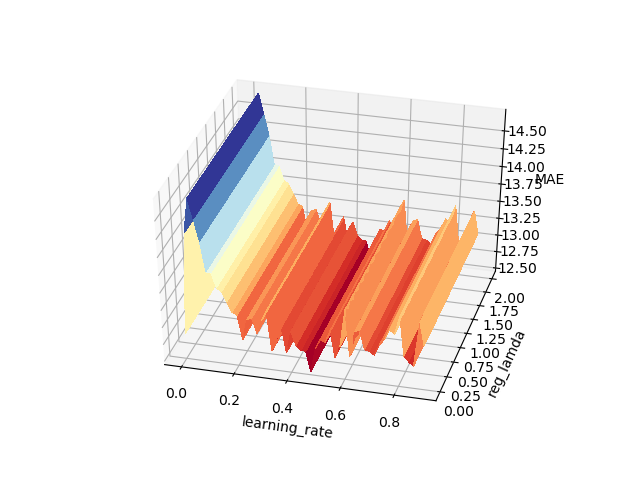

In [61]:
visualize(forestfires_comb3_zoom2, forestfires_comb3_zoom2_meshes, comb=3, dataset_type="reg")

### Forestfires Comb 3 

In [63]:
forestfires_comb3_zoom2, forestfires_comb3_zoom2_meshes = np.load("./np_arrays_50/forestfires_comb3_zoom2.npy", allow_pickle=True)

generate_zoom(forestfires_X, forestfires_y, "./np_arrays_50/forestfires_comb3_zoom2.npy",
             forestfires_comb3_zoom2_meshes, "./np_arrays_50/forestfires_comb3_zoom3.npy",
             zoom1=False, save=False, comb=3, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.        , 0.01815033, 0.03630066, 0.054451  , 0.07260133,
       0.09075166, 0.10890199, 0.12705232, 0.14520266, 0.16335299,
       0.18150332, 0.19965365, 0.21780399, 0.23595432, 0.25410465,
       0.27225498, 0.29040531, 0.30855565, 0.32670598, 0.34485631,
       0.36300664, 0.38115697, 0.39930731, 0.41745764, 0.43560797,
       0.4537583 , 0.47190863, 0.49005897, 0.5082093 , 0.52635963,
       0.54450996, 0.5626603 , 0.58081063, 0.59896096, 0.61711129,
       0.63526162, 0.65341196, 0.67156229, 0.68971262, 0.70786295,
       0.72601328, 0.74416362, 0.76231395, 0.78046428, 0.79861461,
       0.81676494, 0.83491528, 0.85306561, 0.87121594, 0.88936627]), array([0.        , 0.04081633, 0.08163265, 0.12244898, 0.16326531,
       0.20408163, 0.24489796, 0.28571429, 0.32653061, 0.36734694,
       0.40816327, 0.44897959, 0.48979592, 0.53061224, 0.57142857,
       0.6122449 , 0.65306122, 0.69387755, 0.73469388, 0.7755102 ,
       0.81632653, 0.85714286, 0.89795918, 0.93877551, 0.97

No difference

## Forestfires comb 4

In [70]:
forestfires_comb4 = generate_visualization(forestfires_X, forestfires_y, forestfires_ranges, 
                                           resolution=20, comb=4, dataset_type="reg")

In [71]:
#np.save(".\\np_arrays\\forestfires_comb4.npy", forestfires_comb4)

In [72]:
forestfires_comb4 = np.load(".\\np_arrays\\forestfires_comb4.npy")

In [73]:
forestfires_comb4 = 0 - forestfires_comb4

<IPython.core.display.Javascript object>


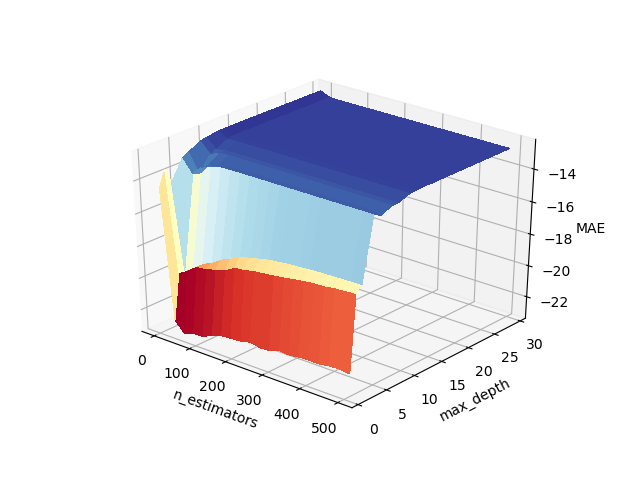

In [74]:
visualize(forestfires_comb4, forestfires_meshes, comb=4, dataset_type="reg")

### Forestfires Comb 4 - Zoom 1

In [64]:
'''
test_s, test_m1, test_m2 = generate_zoom(forestfires_X, forestfires_y, "./np_arrays/forestfires_comb1.npy", forestfires_meshes,
              "evaluation.npy",
             save=True, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''

generate_zoom(forestfires_X, forestfires_y, "np_arrays/forestfires_comb4.npy",
             forestfires_meshes, "np_arrays_50/forestfires_comb4_zoom1.npy",
             zoom1=True, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([  1,  11,  21,  31,  41,  51,  62,  72,  82,  92, 102, 113, 123,
       133, 143, 153, 163, 174, 184, 194, 204, 214, 225, 235, 245, 255,
       265, 275, 286, 296, 306, 316, 326, 337, 347, 357, 367, 377, 387,
       398, 408, 418, 428, 438, 449, 459, 469, 479, 489, 500]), array([ 8,  8,  8,  9,  9, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 14,
       15, 15, 16, 16, 17, 17, 17, 18, 18, 19, 19, 20, 20, 20, 21, 21, 22,
       22, 23, 23, 23, 24, 24, 25, 25, 26, 26, 26, 27, 27, 28, 28, 29]))


In [65]:
forestfires_comb4_zoom1, forestfires_comb4_zoom1_meshes =  generate_zoom(forestfires_X, forestfires_y, "np_arrays/forestfires_comb4.npy",
             forestfires_meshes, "np_arrays_50/forestfires_comb4_zoom1.npy",
             zoom1=True, save=True, comb=4, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)

In [66]:
forestfires_comb4_zoom1, forestfires_comb4_zoom1_meshes = np.load("np_arrays_50/forestfires_comb4_zoom1.npy", 
                                                                  allow_pickle=True)

In [68]:
forestfires_comb4_zoom1 = 0 - forestfires_comb4_zoom1

<IPython.core.display.Javascript object>


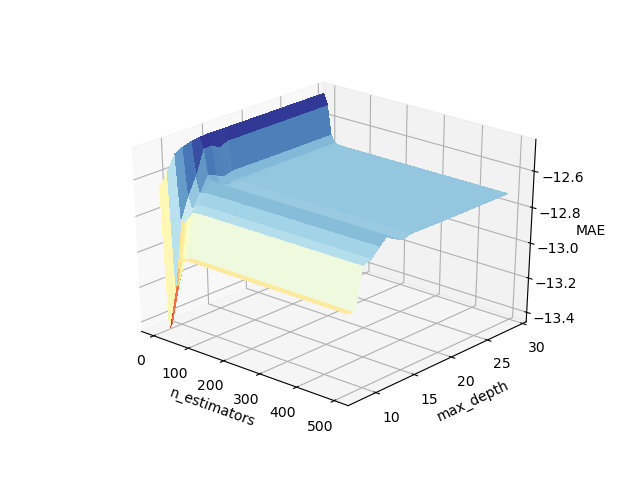

In [69]:
visualize(forestfires_comb4_zoom1, forestfires_comb4_zoom1_meshes, comb=4, dataset_type="reg")

### Forestfires Comb 4 - Zoom 2

In [70]:
'''
generate_zoom(forestfires_X, forestfires_y, "np_arrays/forestfires_comb4.npy",
             forestfires_meshes, "np_arrays_50/forestfires_comb4_zoom1.npy",
             zoom1=True, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)
'''
forestfires_comb4_zoom1, forestfires_comb4_zoom1_meshes = np.load("np_arrays_50/forestfires_comb4_zoom1.npy", 
                                                                  allow_pickle=True)

generate_zoom(forestfires_X, forestfires_y, "./np_arrays_50/forestfires_comb4_zoom1.npy",
             forestfires_comb4_zoom1_meshes, "./np_arrays_50/forestfires_comb4_zoom2.npy",
             zoom1=False, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([  1,  11,  21,  31,  41,  51,  62,  72,  82,  92, 102, 113, 123,
       133, 143, 153, 163, 174, 184, 194, 204, 214, 225, 235, 245, 255,
       265, 275, 286, 296, 306, 316, 326, 337, 347, 357, 367, 377, 387,
       398, 408, 418, 428, 438, 449, 459, 469, 479, 489, 500]), array([ 8,  8,  8,  9,  9, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 14,
       15, 15, 16, 16, 17, 17, 17, 18, 18, 19, 19, 20, 20, 20, 21, 21, 22,
       22, 23, 23, 23, 24, 24, 25, 25, 26, 26, 26, 27, 27, 28, 28, 29]))


No difference

## Forestfires comb 5

In [75]:
forestfires_comb5 = generate_visualization(forestfires_X, forestfires_y, forestfires_ranges,
                                          resolution=20, comb=5, dataset_type="reg")

In [76]:
#np.save(".\\np_arrays\\forestfires_comb5.npy", forestfires_comb5)

In [77]:
forestfires_comb5 = 0 - forestfires_comb5

<IPython.core.display.Javascript object>


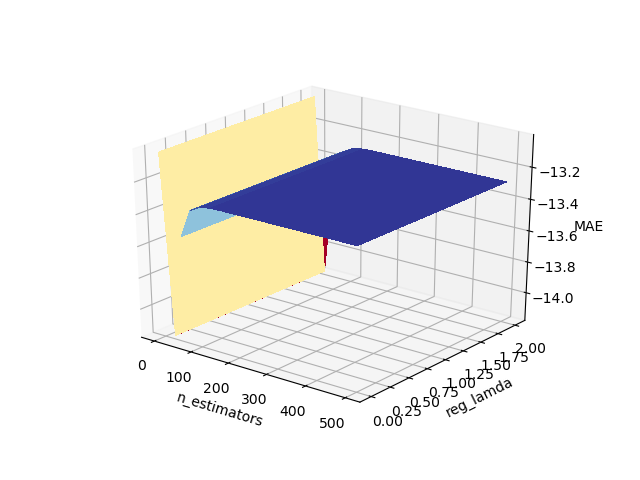

In [78]:
visualize(forestfires_comb5, forestfires_meshes, comb=5, dataset_type="reg")

## Forestfires comb 6

In [79]:
forestfires_comb6 = generate_visualization(forestfires_X, forestfires_y, forestfires_ranges,
                                          resolution=20, comb=6, dataset_type="reg")

In [80]:
#np.save(".\\np_arrays\\forestfires_comb6.npy", forestfires_comb6)

In [81]:
forestfires_comb6 = np.load(".\\np_arrays\\forestfires_comb6.npy")

In [82]:
forestfires_comb6 = 0 - forestfires_comb6

<IPython.core.display.Javascript object>


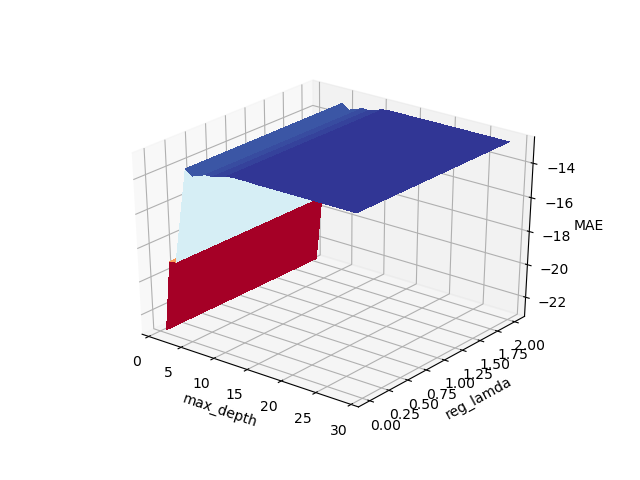

In [83]:
visualize(forestfires_comb6, forestfires_meshes, comb=6, dataset_type="reg")

# Wine (no go... too little variation)

In [14]:
wine = pd.read_csv("wine_shuffled.csv")
wine_X = wine.drop(["0"], axis=1)
wine_y = wine["0"]

In [25]:
wine_learning_rate = np.linspace(0.1,2.0,20)
wine_n_estimators = np.linspace(1,500,20, dtype=int)
wine_max_depth = np.linspace(1,13,20, dtype=int)
wine_reg_lamda = np.linspace(0.0, 2.0, 20)

wine_ranges = (wine_learning_rate, wine_n_estimators, wine_max_depth, wine_reg_lamda)

In [26]:
wine_meshes = generate_meshgrids(wine_ranges)

In [27]:
wine_comb1 = generate_visualization(wine_X, wine_y, wine_ranges, 
                                           resolution=20, comb=1, dataset_type="class")

<IPython.core.display.Javascript object>


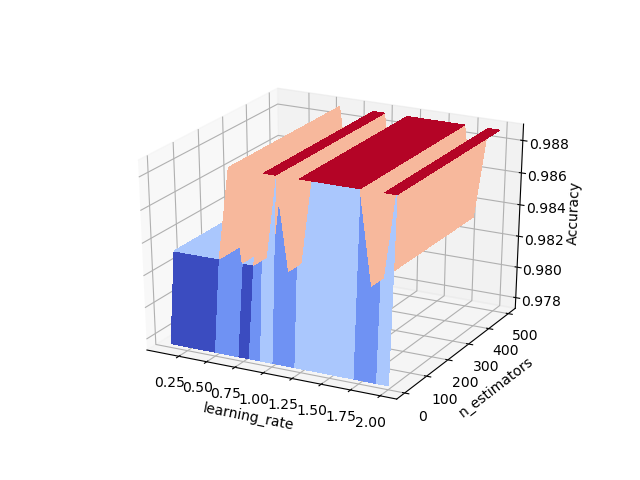

In [32]:
visualize(wine_comb1, wine_meshes, comb=1, dataset_type="class")

In [22]:
wine_comb2 = generate_visualization(wine_X, wine_y, wine_ranges, 
                                   resolution=20, comb=2, dataset_type="class")

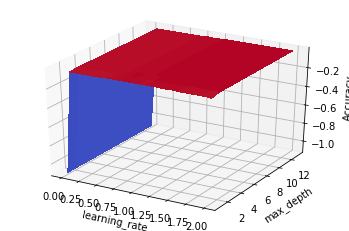

In [23]:
visualize(wine_comb2, wine_meshes, comb=2, dataset_type="class")

In [24]:
wine_comb2[0]

array([0.33146067, 0.97752809, 0.97752809, 0.97752809, 0.97752809,
       0.97752809, 0.98314607, 0.98314607, 0.98314607, 0.98314607,
       0.98314607, 0.98314607, 0.98314607, 0.97752809, 0.98314607,
       0.97752809, 0.97752809, 0.97752809, 0.97752809, 0.97191011])

# wdbc

In [18]:
wdbc = pd.read_csv("wdbc_shuffled.csv")
wdbc_X = wdbc.drop(["1"], axis=1)
wdbc_y = wdbc["1"]

In [19]:
wdbc_learning_rate = np.linspace(0.0,2.0,20)
wdbc_n_estimators = np.linspace(1,500,20, dtype=int)
wdbc_max_depth = np.linspace(1,31,20, dtype=int)
wdbc_reg_lamda = np.linspace(0.0, 2.0, 20)

wdbc_ranges = (wdbc_learning_rate, wdbc_n_estimators, wdbc_max_depth,  wdbc_reg_lamda)

In [20]:
wdbc_meshes = generate_meshgrids(wdbc_ranges)

## wdbc comb 1

In [94]:
wdbc_comb1 = generate_visualization(wdbc_X, wdbc_y, wdbc_ranges,
                                   resolution=20, comb=1, dataset_type="class")

In [95]:
#np.save(".\\np_arrays\\wdbc_comb1.npy", wdbc_comb1)

In [96]:
wdbc_comb1 = np.load(".\\np_arrays\\wdbc_comb1.npy")

<IPython.core.display.Javascript object>


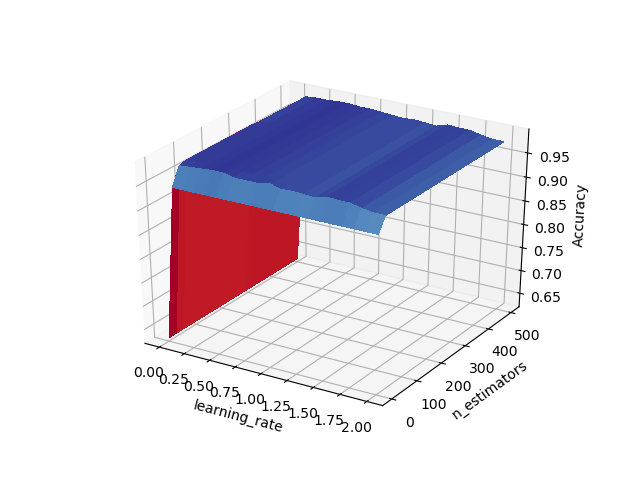

In [97]:
visualize(wdbc_comb1, wdbc_meshes, comb=1, dataset_type="class")

### wdbc Comb 1 - Zoom 1

In [74]:

generate_zoom(wdbc_X, wdbc_y, "./np_arrays/wdbc_comb1.npy",
             wdbc_meshes, "./np_arrays_50/wdbc_comb1_zoom1.npy",
             zoom1=True, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)


(array([0.10526316, 0.13748657, 0.16970999, 0.2019334 , 0.23415682,
       0.26638024, 0.29860365, 0.33082707, 0.36305048, 0.3952739 ,
       0.42749731, 0.45972073, 0.49194415, 0.52416756, 0.55639098,
       0.58861439, 0.62083781, 0.65306122, 0.68528464, 0.71750806,
       0.74973147, 0.78195489, 0.8141783 , 0.84640172, 0.87862513,
       0.91084855, 0.94307197, 0.97529538, 1.0075188 , 1.03974221,
       1.07196563, 1.10418904, 1.13641246, 1.16863588, 1.20085929,
       1.23308271, 1.26530612, 1.29752954, 1.32975295, 1.36197637,
       1.39419979, 1.4264232 , 1.45864662, 1.49087003, 1.52309345,
       1.55531686, 1.58754028, 1.61976369, 1.65198711, 1.68421053]), array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]))


In [75]:
wdbc_comb1_zoom1, wdbc_comb1_zoom1_meshes =  generate_zoom(wdbc_X, wdbc_y, "./np_arrays/wdbc_comb1.npy",
             wdbc_meshes, "./np_arrays_50/wdbc_comb1_zoom1.npy",
             zoom1=True, save=True, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)

In [18]:
wdbc_comb1_zoom1, wdbc_comb1_zoom1_meshes = np.load("./np_arrays_50/wdbc_comb1_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


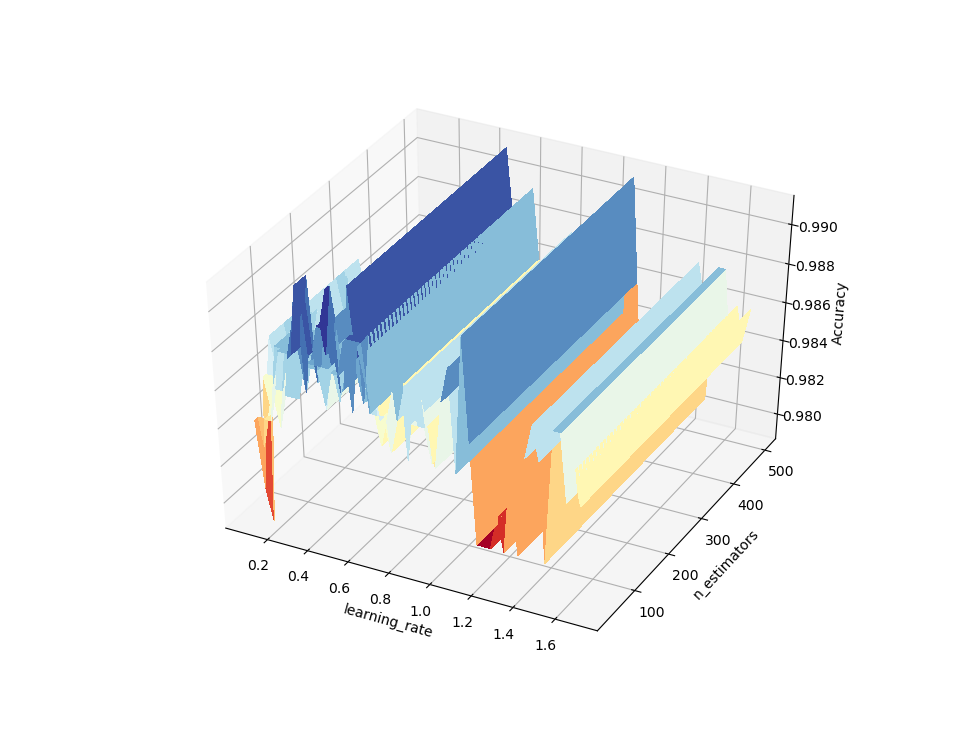

In [19]:
visualize(wdbc_comb1_zoom1, wdbc_comb1_zoom1_meshes, comb=1, dataset_type="class")

### wdbc Comb 1 - Zoom 2

In [78]:
wdbc_comb1_zoom1, wdbc_comb1_zoom1_meshes = np.load("./np_arrays_50/wdbc_comb1_zoom1.npy", allow_pickle=True)

generate_zoom(wdbc_X, wdbc_y, "./np_arrays_50/wdbc_comb1_zoom1.npy",
             wdbc_comb1_zoom1_meshes, "./np_arrays_50/wdbc_comb1_zoom2.npy",
             zoom1=False, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.13748657, 0.16970999, 0.2019334 , 0.23415682,
       0.26638024, 0.29860365, 0.33082707, 0.36305048, 0.3952739 ,
       0.42749731, 0.45972073, 0.49194415, 0.52416756, 0.55639098,
       0.58861439, 0.62083781, 0.65306122, 0.68528464, 0.71750806,
       0.74973147, 0.78195489, 0.8141783 , 0.84640172, 0.87862513,
       0.91084855, 0.94307197, 0.97529538, 1.0075188 , 1.03974221,
       1.07196563, 1.10418904, 1.13641246, 1.16863588, 1.20085929,
       1.23308271, 1.26530612, 1.29752954, 1.32975295, 1.36197637,
       1.39419979, 1.4264232 , 1.45864662, 1.49087003, 1.52309345,
       1.55531686, 1.58754028, 1.61976369, 1.65198711, 1.68421053]), array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]))


No difference.

## wdbc Comb 2

In [98]:
wdbc_comb2 = generate_visualization(wdbc_X, wdbc_y, wdbc_ranges,
                                   resolution=20, comb=2, dataset_type="class")

In [99]:
#np.save(".\\np_arrays\\wdbc_comb2.npy", wdbc_comb2)

In [21]:
wdbc_comb2 = np.load(".\\np_arrays\\wdbc_comb2.npy")

<IPython.core.display.Javascript object>


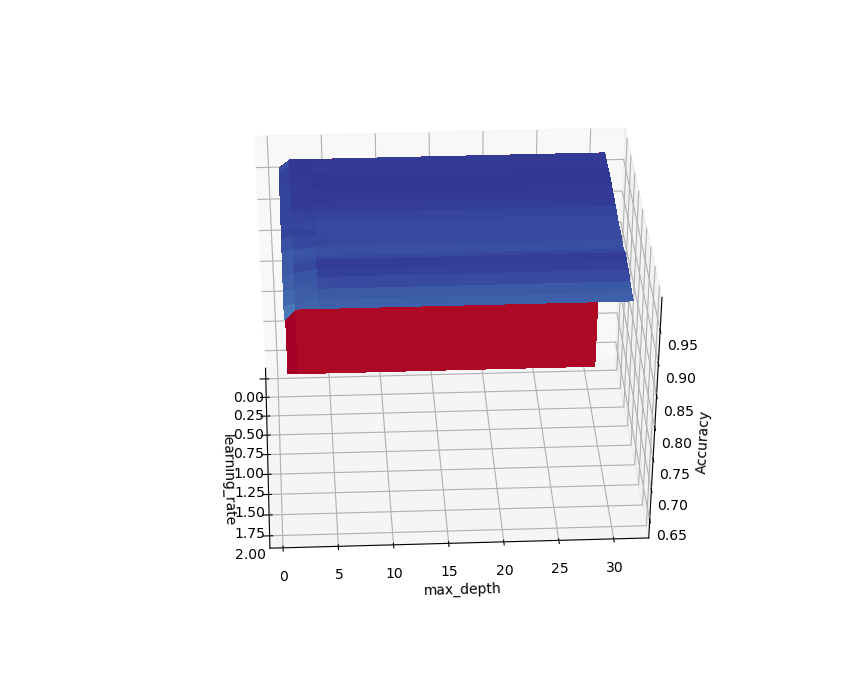

In [22]:
visualize(wdbc_comb2, wdbc_meshes, comb=2, dataset_type="class")

### wdbc Comb 2 - Zoom 1

In [12]:
'''
generate_zoom(forestfires_X, forestfires_y, "np_arrays/forestfires_comb4.npy",
             forestfires_meshes, "np_arrays_50/forestfires_comb4_zoom1.npy",
             zoom1=True, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)
'''

generate_zoom(wdbc_X, wdbc_y, "./np_arrays/wdbc_comb2.npy",
             wdbc_meshes, "./np_arrays_50/wdbc_comb2_zoom1.npy",
             zoom1=True, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

NameError: name 'wdbc_X' is not defined

In [81]:
'''
wdbc_comb2_zoom1, wdbc_comb2_zoom1_meshes =  generate_zoom(wdbc_X, wdbc_y, "./np_arrays/wdbc_comb2.npy",
             wdbc_meshes, "./np_arrays_50/wdbc_comb2_zoom1.npy",
             zoom1=True, save=True, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)
'''

In [16]:
wdbc_comb2_zoom1, wdbc_comb2_zoom1_meshes = np.load("./np_arrays_50/wdbc_comb2_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


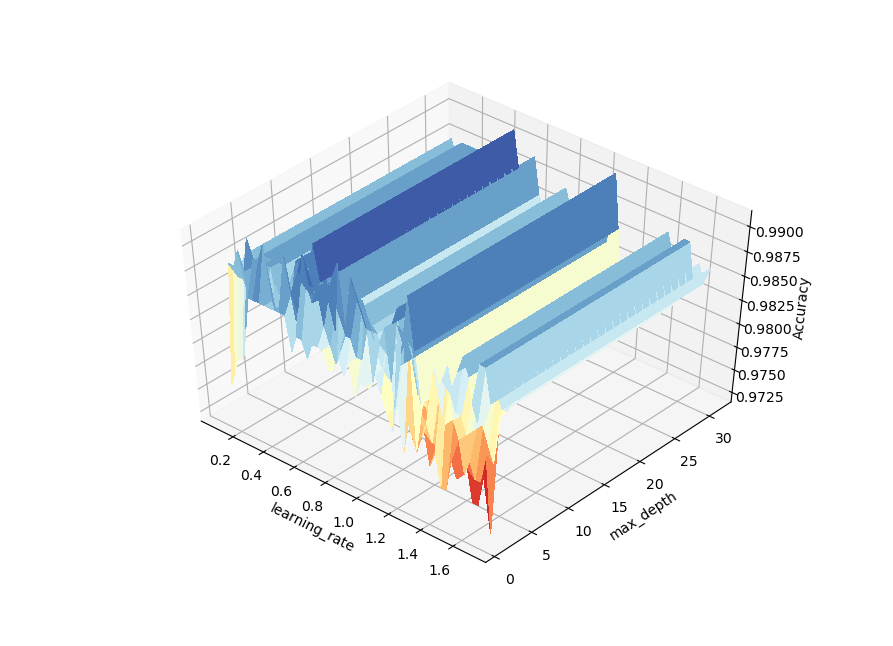

In [17]:
visualize(wdbc_comb2_zoom1, wdbc_comb2_zoom1_meshes, comb=2, dataset_type="class")

### wdbc Comb 2 - Zoom 2

In [84]:
wdbc_comb2_zoom1, wdbc_comb2_zoom1_meshes = np.load("./np_arrays_50/wdbc_comb2_zoom1.npy", allow_pickle=True)

generate_zoom(wdbc_X, wdbc_y, "./np_arrays_50/wdbc_comb2_zoom1.npy",
             wdbc_comb2_zoom1_meshes, "./np_arrays_50/wdbc_comb2_zoom2.npy",
             zoom1=False, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.13748657, 0.16970999, 0.2019334 , 0.23415682,
       0.26638024, 0.29860365, 0.33082707, 0.36305048, 0.3952739 ,
       0.42749731, 0.45972073, 0.49194415, 0.52416756, 0.55639098,
       0.58861439, 0.62083781, 0.65306122, 0.68528464, 0.71750806,
       0.74973147, 0.78195489, 0.8141783 , 0.84640172, 0.87862513,
       0.91084855, 0.94307197, 0.97529538, 1.0075188 , 1.03974221,
       1.07196563, 1.10418904, 1.13641246, 1.16863588, 1.20085929,
       1.23308271, 1.26530612, 1.29752954, 1.32975295, 1.36197637,
       1.39419979, 1.4264232 , 1.45864662, 1.49087003, 1.52309345,
       1.55531686, 1.58754028, 1.61976369, 1.65198711, 1.68421053]), array([ 1,  1,  2,  2,  3,  4,  4,  5,  5,  6,  7,  7,  8,  8,  9, 10, 10,
       11, 12, 12, 13, 13, 14, 15, 15, 16, 16, 17, 18, 18, 19, 19, 20, 21,
       21, 22, 23, 23, 24, 24, 25, 26, 26, 27, 27, 28, 29, 29, 30, 31]))


No difference.

## wdbc comb 3

In [102]:
wdbc_comb3 = generate_visualization(wdbc_X, wdbc_y, wdbc_ranges,
                                   resolution=20, comb=3, dataset_type="class")

In [103]:
#np.save(".\\np_arrays\\wdbc_comb3.npy", wdbc_comb3)

In [104]:
wdbc_comb3 = np.load(".\\np_arrays\\wdbc_comb3.npy")

<IPython.core.display.Javascript object>


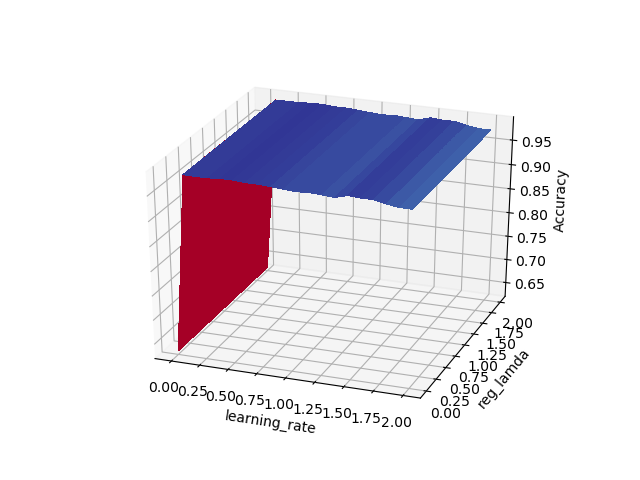

In [105]:
visualize(wdbc_comb3, wdbc_meshes, comb=3, dataset_type="class")

## wdbc Comb 4

In [11]:
wdbc_comb4 = generate_visualization(wdbc_X, wdbc_y, wdbc_ranges,
                                   resolution=20, comb=4, dataset_type="class")

In [12]:
#np.save(".\\np_arrays\\wdbc_comb4.npy", wdbc_comb4)

In [13]:
wdbc_comb4 = np.load(".\\np_arrays\\wdbc_comb4.npy")

<IPython.core.display.Javascript object>


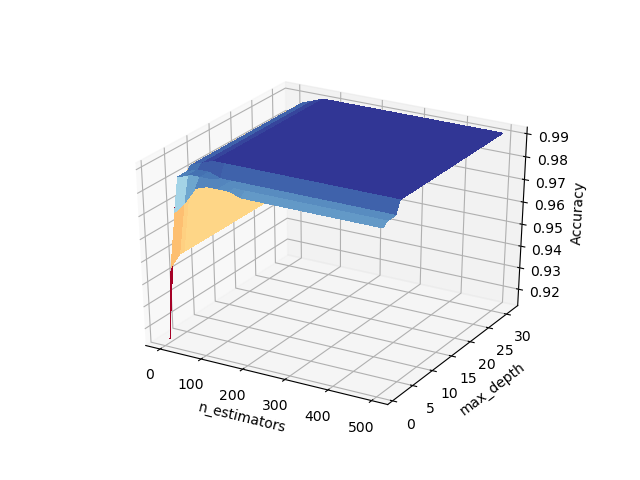

In [16]:
visualize(wdbc_comb4, wdbc_meshes, comb=4, dataset_type="class")

### wdbc Comb 4 - Zoom 1

In [85]:
'''
generate_zoom(wdbc_X, wdbc_y, "./np_arrays/wdbc_comb2.npy",
             wdbc_meshes, "./np_arrays_50/wdbc_comb2_zoom1.npy",
             zoom1=True, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)
'''
generate_zoom(wdbc_X, wdbc_y, "./np_arrays/wdbc_comb4.npy",
             wdbc_meshes, "./np_arrays_50/wdbc_comb4_zoom1.npy",
             zoom1=True, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([ 79,  87,  96, 104, 113, 121, 130, 139, 147, 156, 164, 173, 182,
       190, 199, 207, 216, 225, 233, 242, 250, 259, 268, 276, 285, 293,
       302, 310, 319, 328, 336, 345, 353, 362, 371, 379, 388, 396, 405,
       414, 422, 431, 439, 448, 457, 465, 474, 482, 491, 500]), array([ 5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13,
       14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22,
       23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 31]))


In [86]:
wdbc_comb4_zoom1, wdbc_comb4_zoom1_meshes = generate_zoom(wdbc_X, wdbc_y, "./np_arrays/wdbc_comb4.npy",
             wdbc_meshes, "./np_arrays_50/wdbc_comb4_zoom1.npy",
             zoom1=True, save=True, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)

In [87]:
wdbc_comb4_zoom1, wdbc_comb4_zoom1_meshes = np.load("./np_arrays_50/wdbc_comb4_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


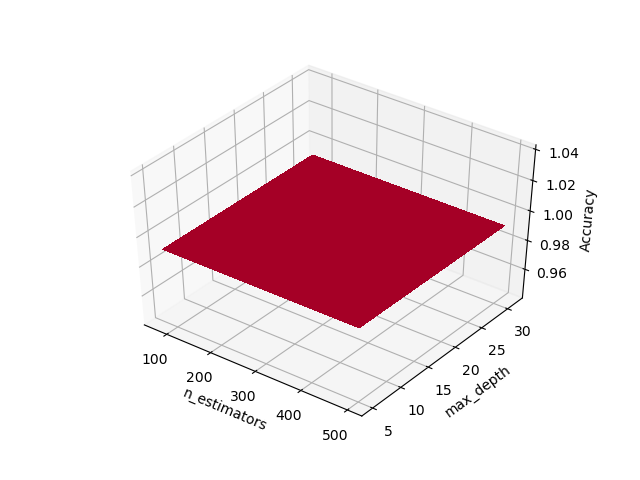

In [88]:
visualize(wdbc_comb4_zoom1, wdbc_comb4_zoom1_meshes, comb=4, dataset_type="class")

## wdbc comb 5

In [17]:
wdbc_comb5 = generate_visualization(wdbc_X, wdbc_y, wdbc_ranges,
                                   resolution=20, comb=5, dataset_type="class")

In [18]:
#np.save(".\\np_arrays\\wdbc_comb5.npy", wdbc_comb5)

In [19]:
wdbc_comb5 = np.load(".\\np_arrays\\wdbc_comb5.npy")

<IPython.core.display.Javascript object>


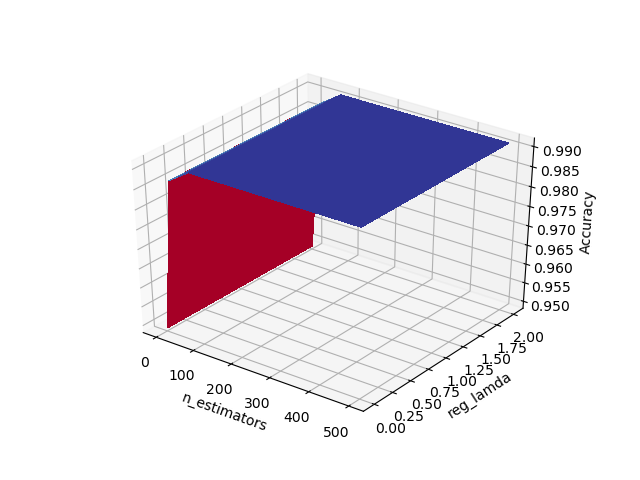

In [20]:
visualize(wdbc_comb5, wdbc_meshes, comb=5, dataset_type="class")

## wdbc comb 6

In [21]:
wdbc_comb6 = generate_visualization(wdbc_X, wdbc_y, wdbc_ranges,
                                   resolution=20, comb=6, dataset_type="class")

In [22]:
#np.save(".\\np_arrays\\wdbc_comb6.npy", wdbc_comb6)

In [23]:
wdbc_comb6 = np.load(".\\np_arrays\\wdbc_comb6.npy")

<IPython.core.display.Javascript object>


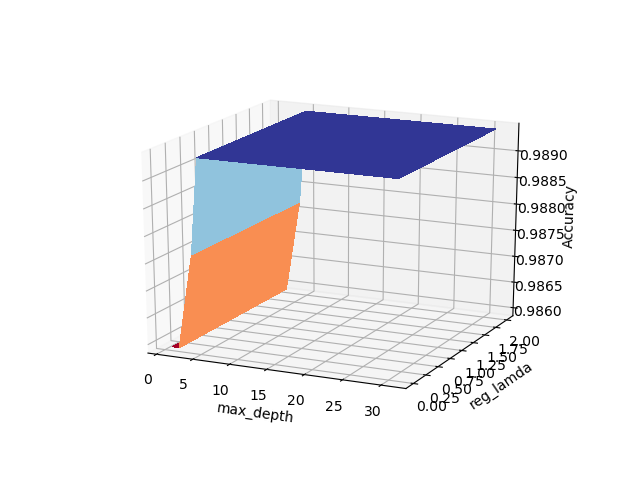

In [24]:
visualize(wdbc_comb6, wdbc_meshes, comb=6, dataset_type="class")

# Biodeg

In [9]:
biodeg = pd.read_csv("biodeg_shuffled.csv")
biodeg_X = biodeg.drop(["41"], axis=1)
biodeg_y = biodeg["41"]

In [10]:
biodeg_learning_rate = np.linspace(0.0,2.0,20)
biodeg_n_estimators = np.linspace(1,500,20, dtype=int)
biodeg_max_depth = np.linspace(1,41,20, dtype=int)
biodeg_reg_lamda = np.linspace(0.0, 2.0, 20)

biodeg_ranges = (biodeg_learning_rate, biodeg_n_estimators, biodeg_max_depth, biodeg_reg_lamda)

In [11]:
biodeg_meshes = generate_meshgrids(biodeg_ranges)

## Biodeg Comb 1

In [93]:
'''
wdbc_comb1 = generate_visualization(wdbc_X, wdbc_y, wdbc_ranges,
                                   resolution=20, comb=1, dataset_type="class")
'''

biodeg_comb1 = generate_visualization(biodeg_X, biodeg_y, biodeg_ranges, resolution=20, comb=1, dataset_type="class")

In [94]:
#np.save("./np_arrays/biodeg_comb1.npy", biodeg_comb1)

In [95]:
biodeg_comb1 = np.load("./np_arrays/biodeg_comb1.npy")

<IPython.core.display.Javascript object>


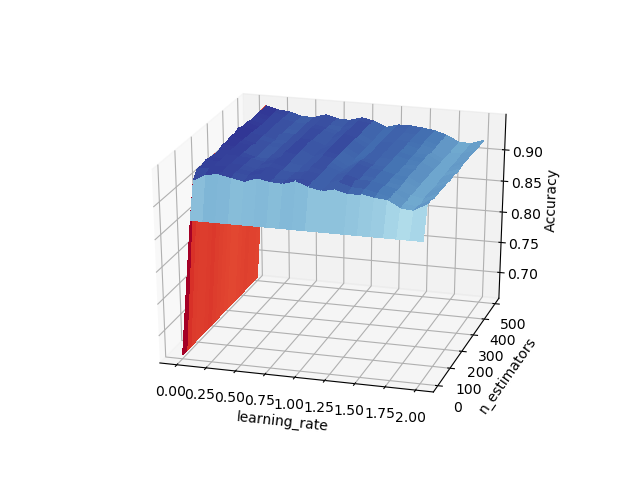

In [96]:
visualize(biodeg_comb1, biodeg_meshes, comb=1, dataset_type="class")

### Biodeg Comb 1 - Zoom 1

In [12]:
generate_zoom(biodeg_X, biodeg_y, "./np_arrays/biodeg_comb1.npy",
             biodeg_meshes, "./np_arrays_50/biodeg_comb1_zoom1.npy",
             zoom1=True, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.13104189, 0.15682062, 0.18259936, 0.20837809,
       0.23415682, 0.25993555, 0.28571429, 0.31149302, 0.33727175,
       0.36305048, 0.38882922, 0.41460795, 0.44038668, 0.46616541,
       0.49194415, 0.51772288, 0.54350161, 0.56928034, 0.59505908,
       0.62083781, 0.64661654, 0.67239527, 0.69817401, 0.72395274,
       0.74973147, 0.7755102 , 0.80128894, 0.82706767, 0.8528464 ,
       0.87862513, 0.90440387, 0.9301826 , 0.95596133, 0.98174006,
       1.0075188 , 1.03329753, 1.05907626, 1.08485499, 1.11063373,
       1.13641246, 1.16219119, 1.18796992, 1.21374866, 1.23952739,
       1.26530612, 1.29108485, 1.31686359, 1.34264232, 1.36842105]), array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]))


In [13]:
biodeg_comb1_zoom1, biodeg_comb1_zoom1_meshes = generate_zoom(biodeg_X, biodeg_y, "./np_arrays/biodeg_comb1.npy",
             biodeg_meshes, "./np_arrays_50/biodeg_comb1_zoom1.npy",
             zoom1=True, save=True, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)

In [14]:
#wdbc_comb4_zoom1, wdbc_comb4_zoom1_meshes = np.load("./np_arrays_50/wdbc_comb4_zoom1.npy", allow_pickle=True)
biodeg_comb1_zoom1, biodeg_comb1_zoom1_meshes = np.load("./np_arrays_50/biodeg_comb1_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


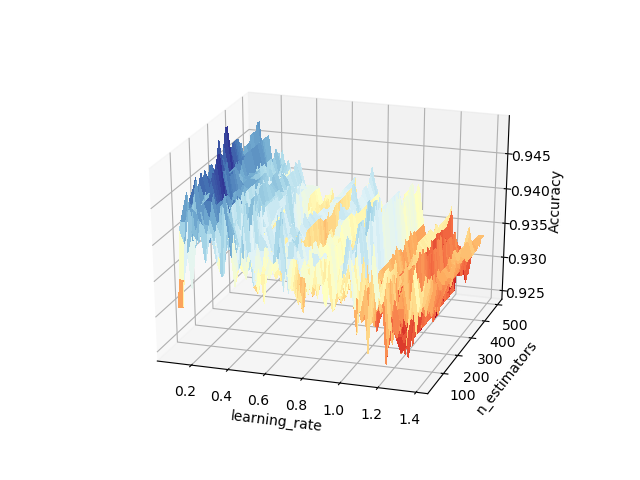

In [17]:
#visualize(wdbc_comb4_zoom1, wdbc_comb4_zoom1_meshes, comb=4, dataset_type="class")
visualize(biodeg_comb1_zoom1, biodeg_comb1_zoom1_meshes, comb=1, dataset_type="class")

### Biodeg Comb 1 - Zoom 2

In [18]:
generate_zoom(biodeg_X, biodeg_y, "./np_arrays_50/biodeg_comb1_zoom1.npy",
             biodeg_comb1_zoom1_meshes, "./np_arrays_50/biodeg_comb1_zoom2.npy",
             zoom1=False, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.13104189, 0.15682062, 0.18259936, 0.20837809,
       0.23415682, 0.25993555, 0.28571429, 0.31149302, 0.33727175,
       0.36305048, 0.38882922, 0.41460795, 0.44038668, 0.46616541,
       0.49194415, 0.51772288, 0.54350161, 0.56928034, 0.59505908,
       0.62083781, 0.64661654, 0.67239527, 0.69817401, 0.72395274,
       0.74973147, 0.7755102 , 0.80128894, 0.82706767, 0.8528464 ,
       0.87862513, 0.90440387, 0.9301826 , 0.95596133, 0.98174006,
       1.0075188 , 1.03329753, 1.05907626, 1.08485499, 1.11063373,
       1.13641246, 1.16219119, 1.18796992, 1.21374866, 1.23952739,
       1.26530612, 1.29108485, 1.31686359, 1.34264232, 1.36842105]), array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]))


No difference.

## Biodeg Comb 2

In [97]:
biodeg_comb2 = generate_visualization(biodeg_X, biodeg_y, biodeg_ranges, resolution=20, comb=2, dataset_type="class")

In [98]:
#np.save("./np_arrays/biodeg_comb2.npy", biodeg_comb2)

In [99]:
biodeg_comb2 = np.load("./np_arrays/biodeg_comb2.npy")

<IPython.core.display.Javascript object>


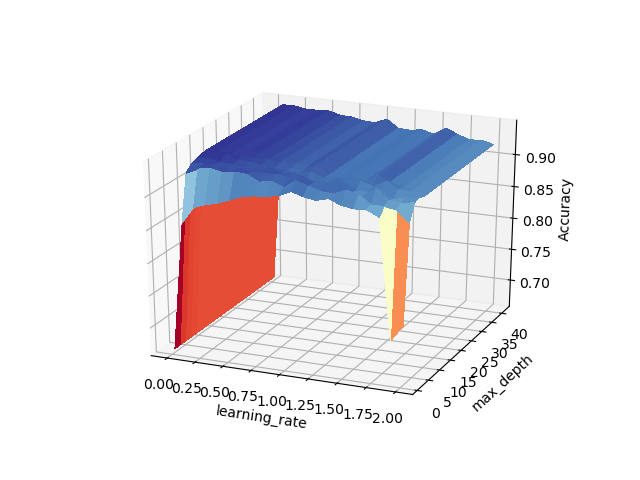

In [100]:
visualize(biodeg_comb2, biodeg_meshes, comb=2, dataset_type="class")

### Biodeg Comb 2 - Zoom 1

In [19]:
generate_zoom(biodeg_X, biodeg_y, "./np_arrays/biodeg_comb2.npy",
             biodeg_meshes, "./np_arrays_50/biodeg_comb2_zoom1.npy",
             zoom1=True, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.13748657, 0.16970999, 0.2019334 , 0.23415682,
       0.26638024, 0.29860365, 0.33082707, 0.36305048, 0.3952739 ,
       0.42749731, 0.45972073, 0.49194415, 0.52416756, 0.55639098,
       0.58861439, 0.62083781, 0.65306122, 0.68528464, 0.71750806,
       0.74973147, 0.78195489, 0.8141783 , 0.84640172, 0.87862513,
       0.91084855, 0.94307197, 0.97529538, 1.0075188 , 1.03974221,
       1.07196563, 1.10418904, 1.13641246, 1.16863588, 1.20085929,
       1.23308271, 1.26530612, 1.29752954, 1.32975295, 1.36197637,
       1.39419979, 1.4264232 , 1.45864662, 1.49087003, 1.52309345,
       1.55531686, 1.58754028, 1.61976369, 1.65198711, 1.68421053]), array([ 3,  3,  4,  5,  6,  6,  7,  8,  9,  9, 10, 11, 12, 13, 13, 14, 15,
       16, 16, 17, 18, 19, 20, 20, 21, 22, 23, 23, 24, 25, 26, 27, 27, 28,
       29, 30, 30, 31, 32, 33, 34, 34, 35, 36, 37, 37, 38, 39, 40, 41]))


In [20]:
biodeg_comb2_zoom1, biodeg_comb2_zoom1 = generate_zoom(biodeg_X, biodeg_y, "./np_arrays/biodeg_comb2.npy",
             biodeg_meshes, "./np_arrays_50/biodeg_comb2_zoom1.npy",
             zoom1=True, save=True, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)

In [10]:
biodeg_comb2_zoom1, biodeg_comb2_zoom1_meshes = np.load("./np_arrays_50/biodeg_comb2_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


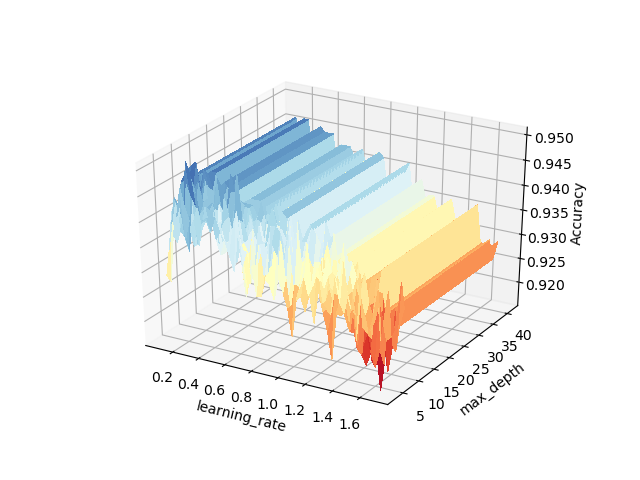

In [11]:
visualize(biodeg_comb2_zoom1, biodeg_comb2_zoom1_meshes, comb=2, dataset_type="class")

### Biodeg Comb 2 - Zoom 2

In [26]:
generate_zoom(biodeg_X, biodeg_y, "./np_arrays_50/biodeg_comb2_zoom1.npy",
             biodeg_comb2_zoom1_meshes, "./np_arrays_50/biodeg_comb2_zoom2.npy",
             zoom1=False, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.13354085, 0.16181854, 0.19009623, 0.21837392,
       0.24665161, 0.27492931, 0.303207  , 0.33148469, 0.35976238,
       0.38804007, 0.41631776, 0.44459545, 0.47287314, 0.50115084,
       0.52942853, 0.55770622, 0.58598391, 0.6142616 , 0.64253929,
       0.67081698, 0.69909468, 0.72737237, 0.75565006, 0.78392775,
       0.81220544, 0.84048313, 0.86876082, 0.89703851, 0.92531621,
       0.9535939 , 0.98187159, 1.01014928, 1.03842697, 1.06670466,
       1.09498235, 1.12326005, 1.15153774, 1.17981543, 1.20809312,
       1.23637081, 1.2646485 , 1.29292619, 1.32120388, 1.34948158,
       1.37775927, 1.40603696, 1.43431465, 1.46259234, 1.49087003]), array([ 3,  3,  4,  5,  6,  6,  7,  8,  9,  9, 10, 11, 12, 13, 13, 14, 15,
       16, 16, 17, 18, 19, 20, 20, 21, 22, 23, 23, 24, 25, 26, 27, 27, 28,
       29, 30, 30, 31, 32, 33, 34, 34, 35, 36, 37, 37, 38, 39, 40, 41]))


In [27]:
biodeg_comb2_zoom2, biodeg_comb2_zoom2_meshes = generate_zoom(biodeg_X, biodeg_y, "./np_arrays_50/biodeg_comb2_zoom1.npy",
             biodeg_comb2_zoom1_meshes, "./np_arrays_50/biodeg_comb2_zoom2.npy",
             zoom1=False, save=True, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)

In [28]:
biodeg_comb2_zoom2, biodeg_comb2_zoom2_meshes = np.load("./np_arrays_50/biodeg_comb2_zoom2.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


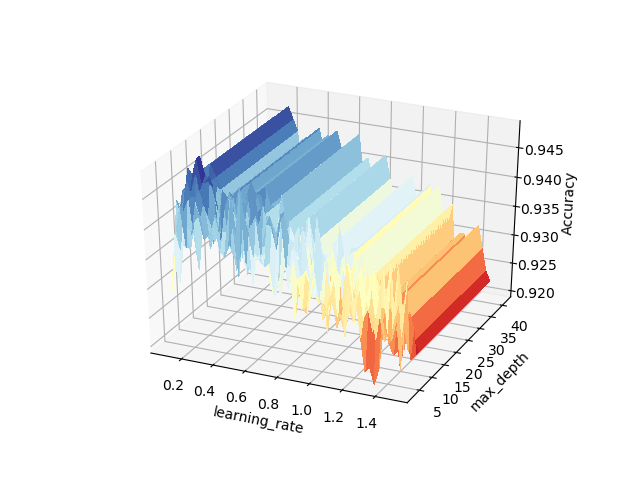

In [29]:
visualize(biodeg_comb2_zoom2, biodeg_comb2_zoom2_meshes, comb=2, dataset_type="class")

### Biodeg Comb 2 - Zoom 3

In [30]:
generate_zoom(biodeg_X, biodeg_y, "./np_arrays_50/biodeg_comb2_zoom2.npy",
             biodeg_comb2_zoom2_meshes, "./np_arrays_50/biodeg_comb2_zoom3.npy",
             zoom1=False, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.13180956, 0.15835597, 0.18490237, 0.21144877,
       0.23799518, 0.26454158, 0.29108799, 0.31763439, 0.34418079,
       0.3707272 , 0.3972736 , 0.42382001, 0.45036641, 0.47691282,
       0.50345922, 0.53000562, 0.55655203, 0.58309843, 0.60964484,
       0.63619124, 0.66273764, 0.68928405, 0.71583045, 0.74237686,
       0.76892326, 0.79546966, 0.82201607, 0.84856247, 0.87510888,
       0.90165528, 0.92820168, 0.95474809, 0.98129449, 1.0078409 ,
       1.0343873 , 1.06093371, 1.08748011, 1.11402651, 1.14057292,
       1.16711932, 1.19366573, 1.22021213, 1.24675853, 1.27330494,
       1.29985134, 1.32639775, 1.35294415, 1.37949055, 1.40603696]), array([ 3,  3,  4,  5,  6,  6,  7,  8,  9,  9, 10, 11, 12, 13, 13, 14, 15,
       16, 16, 17, 18, 19, 20, 20, 21, 22, 23, 23, 24, 25, 26, 27, 27, 28,
       29, 30, 30, 31, 32, 33, 34, 34, 35, 36, 37, 37, 38, 39, 40, 41]))


Maybe...

## Biodeg Comb 3

In [101]:
biodeg_comb3 = generate_visualization(biodeg_X, biodeg_y, biodeg_ranges, resolution=20, comb=3, dataset_type="class")

In [102]:
#np.save("./np_arrays/biodeg_comb3.npy", biodeg_comb3)

In [103]:
biodeg_comb3 = np.load("./np_arrays/biodeg_comb3.npy")

<IPython.core.display.Javascript object>


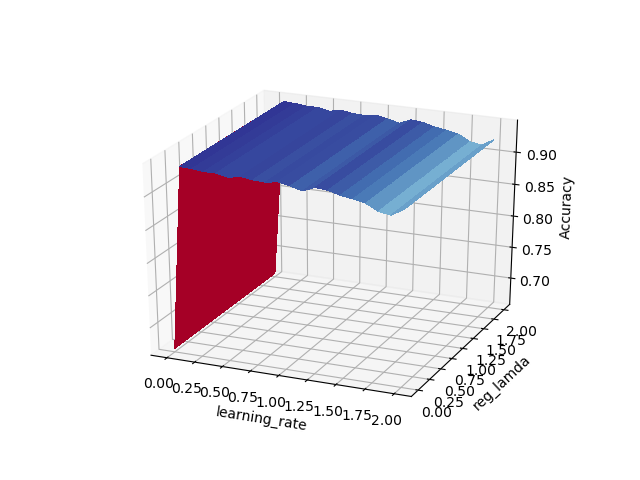

In [104]:
visualize(biodeg_comb3, biodeg_meshes, comb=3, dataset_type="class")

## Biodeg Comb 4

In [105]:
biodeg_comb4 = generate_visualization(biodeg_X, biodeg_y, biodeg_ranges, resolution=20, comb=4, dataset_type="class")

In [106]:
#np.save("./np_arrays/biodeg_comb4.npy", biodeg_comb4)

In [107]:
biodeg_comb4 = np.load("./np_arrays/biodeg_comb4.npy")

<IPython.core.display.Javascript object>


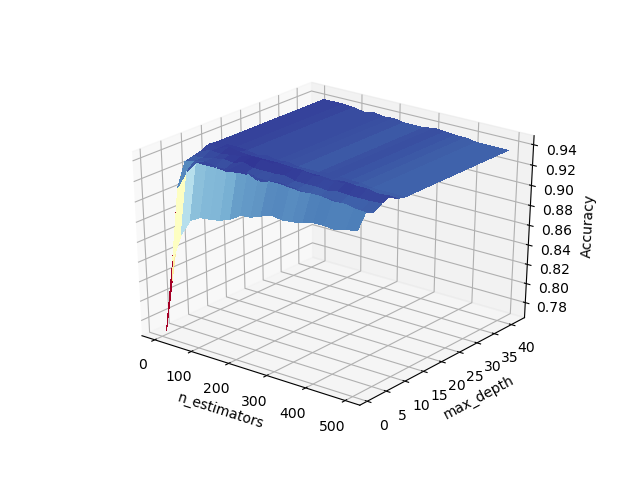

In [108]:
visualize(biodeg_comb4, biodeg_meshes, comb=4, dataset_type="class")

### Biodeg Comb 4 - Zoom 1

In [31]:
generate_zoom(biodeg_X, biodeg_y, "./np_arrays/biodeg_comb4.npy",
             biodeg_meshes, "./np_arrays_50/biodeg_comb4_zoom1.npy",
             zoom1=True, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]), array([ 3,  3,  4,  5,  6,  6,  7,  8,  9,  9, 10, 11, 12, 13, 13, 14, 15,
       16, 16, 17, 18, 19, 20, 20, 21, 22, 23, 23, 24, 25, 26, 27, 27, 28,
       29, 30, 30, 31, 32, 33, 34, 34, 35, 36, 37, 37, 38, 39, 40, 41]))


In [32]:
biodeg_comb4_zoom1, biodeg_comb4_zoom1_meshes = generate_zoom(biodeg_X, biodeg_y, "./np_arrays/biodeg_comb4.npy",
             biodeg_meshes, "./np_arrays_50/biodeg_comb4_zoom1.npy",
             zoom1=True, save=True, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)

In [33]:
biodeg_comb4_zoom1, biodeg_comb4_zoom1_meshes = np.load("./np_arrays_50/biodeg_comb4_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


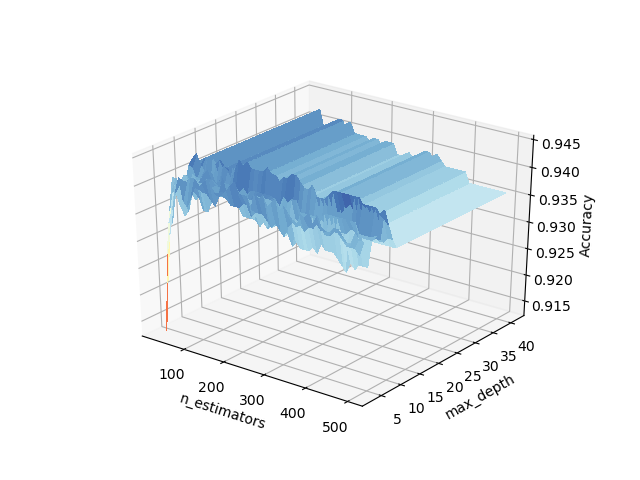

In [34]:
visualize(biodeg_comb4_zoom1, biodeg_comb4_zoom1_meshes, comb=4, dataset_type="class")

### Biodeg Comb 4 - Zoom 2

In [35]:
generate_zoom(biodeg_X, biodeg_y, "./np_arrays_50/biodeg_comb4_zoom1.npy",
             biodeg_comb4_zoom1_meshes, "./np_arrays_50/biodeg_comb4_zoom2.npy",
             zoom1=False, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]), array([ 3,  3,  4,  5,  6,  6,  7,  8,  9,  9, 10, 11, 12, 13, 13, 14, 15,
       16, 16, 17, 18, 19, 20, 20, 21, 22, 23, 23, 24, 25, 26, 27, 27, 28,
       29, 30, 30, 31, 32, 33, 34, 34, 35, 36, 37, 37, 38, 39, 40, 41]))


No difference.

## Biodeg Comb 5

In [109]:
biodeg_comb5 = generate_visualization(biodeg_X, biodeg_y, biodeg_ranges, resolution=20, comb=5, dataset_type="class")

In [110]:
#np.save("./np_arrays/biodeg_comb5.npy", biodeg_comb5)

In [111]:
biodeg_comb5 = np.load("./np_arrays/biodeg_comb5.npy")

<IPython.core.display.Javascript object>


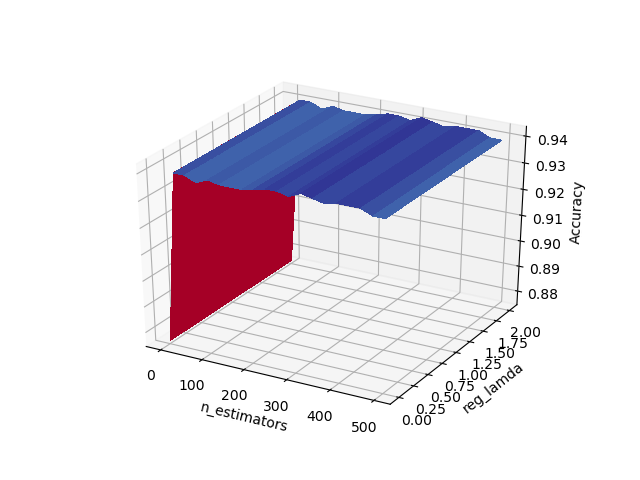

In [112]:
visualize(biodeg_comb5, biodeg_meshes, comb=5, dataset_type="class")

## Biodeg Comb 6

In [113]:
biodeg_comb6 = generate_visualization(biodeg_X, biodeg_y, biodeg_ranges, resolution=20, comb=6, dataset_type="class")

In [114]:
#np.save("./np_arrays/biodeg_comb6.npy", biodeg_comb6)

In [115]:
biodeg_comb6 = np.load("./np_arrays/biodeg_comb6.npy")

<IPython.core.display.Javascript object>


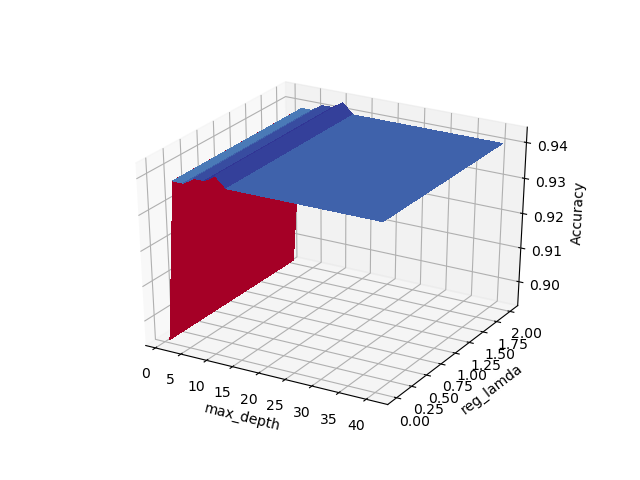

In [116]:
visualize(biodeg_comb6, biodeg_meshes, comb=6, dataset_type="class")

# Contraceptive

In [9]:
cmc = pd.read_csv("cmc_shuffled.csv")
cmc_X = cmc.drop(["9"], axis=1)
cmc_y = cmc["9"]

In [9]:
cmc_learning_rate = np.linspace(0.0,2.0,20)
cmc_n_estimators = np.linspace(1,500,20, dtype=int)
cmc_max_depth = np.linspace(1,9,20, dtype=int)
cmc_reg_lamda = np.linspace(0.0, 2.0, 20)

cmc_ranges = (cmc_learning_rate, cmc_n_estimators, cmc_max_depth, cmc_reg_lamda)

In [10]:
cmc_meshes = generate_meshgrids(cmc_ranges)

## Contraceptive Comb 1

In [120]:
#biodeg_comb6 = generate_visualization(biodeg_X, biodeg_y, biodeg_ranges, resolution=20, comb=6, dataset_type="class")
cmc_comb1 = generate_visualization(cmc_X, cmc_y, cmc_ranges, resolution=20, comb=1, dataset_type="class")

In [121]:
#np.save("./np_arrays/cmc_comb1.npy", cmc_comb1)

In [122]:
cmc_comb1 = np.load("./np_arrays/cmc_comb1.npy")

<IPython.core.display.Javascript object>


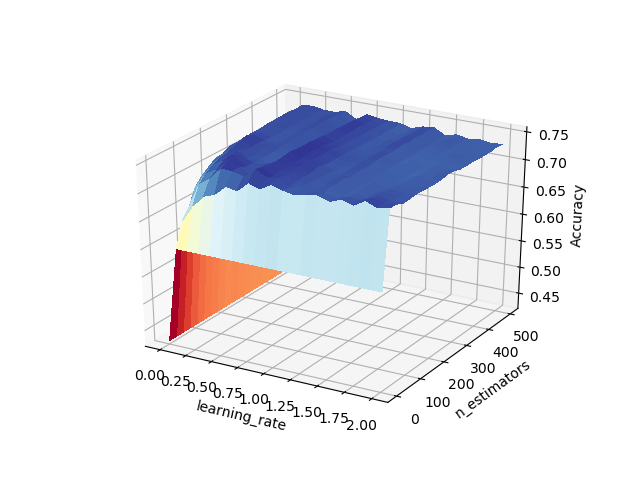

In [123]:
visualize(cmc_comb1, cmc_meshes, comb=1, dataset_type="class")

### Contraceptive Comb 1 - Zoom 1

In [39]:
generate_zoom(cmc_X, cmc_y, "./np_arrays/cmc_comb1.npy",
             cmc_meshes, "./np_arrays_50/cmc_comb1_zoom1.npy",
             zoom1=True, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.14393126, 0.18259936, 0.22126745, 0.25993555,
       0.29860365, 0.33727175, 0.37593985, 0.41460795, 0.45327605,
       0.49194415, 0.53061224, 0.56928034, 0.60794844, 0.64661654,
       0.68528464, 0.72395274, 0.76262084, 0.80128894, 0.83995704,
       0.87862513, 0.91729323, 0.95596133, 0.99462943, 1.03329753,
       1.07196563, 1.11063373, 1.14930183, 1.18796992, 1.22663802,
       1.26530612, 1.30397422, 1.34264232, 1.38131042, 1.41997852,
       1.45864662, 1.49731472, 1.53598281, 1.57465091, 1.61331901,
       1.65198711, 1.69065521, 1.72932331, 1.76799141, 1.80665951,
       1.8453276 , 1.8839957 , 1.9226638 , 1.9613319 , 2.        ]), array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]))


In [40]:
cmc_comb1_zoom1, cmc_comb1_zoom1_meshes = generate_zoom(cmc_X, cmc_y, "./np_arrays/cmc_comb1.npy",
             cmc_meshes, "./np_arrays_50/cmc_comb1_zoom1.npy",
             zoom1=True, save=True, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)

In [41]:
cmc_comb1_zoom1, cmc_comb1_zoom1_meshes = np.load("./np_arrays_50/cmc_comb1_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


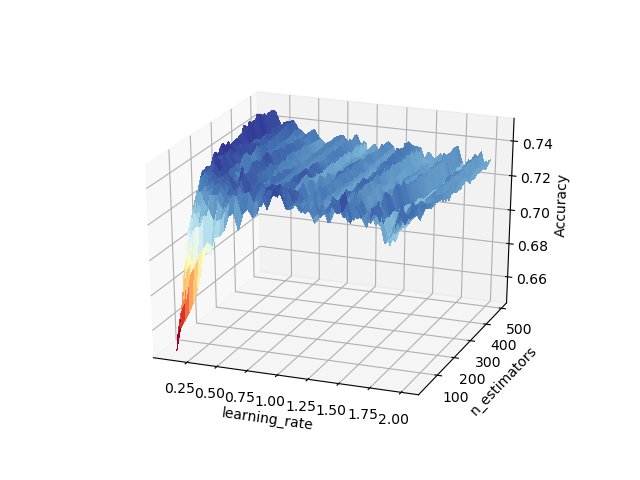

In [42]:
visualize(cmc_comb1_zoom1, cmc_comb1_zoom1_meshes, comb=1, dataset_type="class")

### Contraceptive Comb 1 - Zoom 2

In [43]:
generate_zoom(cmc_X, cmc_y, "./np_arrays_50/cmc_comb1_zoom1.npy",
             cmc_comb1_zoom1_meshes, "./np_arrays_50/cmc_comb1_zoom2.npy",
             zoom1=False, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.14393126, 0.18259936, 0.22126745, 0.25993555,
       0.29860365, 0.33727175, 0.37593985, 0.41460795, 0.45327605,
       0.49194415, 0.53061224, 0.56928034, 0.60794844, 0.64661654,
       0.68528464, 0.72395274, 0.76262084, 0.80128894, 0.83995704,
       0.87862513, 0.91729323, 0.95596133, 0.99462943, 1.03329753,
       1.07196563, 1.11063373, 1.14930183, 1.18796992, 1.22663802,
       1.26530612, 1.30397422, 1.34264232, 1.38131042, 1.41997852,
       1.45864662, 1.49731472, 1.53598281, 1.57465091, 1.61331901,
       1.65198711, 1.69065521, 1.72932331, 1.76799141, 1.80665951,
       1.8453276 , 1.8839957 , 1.9226638 , 1.9613319 , 2.        ]), array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]))


No difference.

## Contraceptive Comb 2

In [124]:
cmc_comb2 = generate_visualization(cmc_X, cmc_y, cmc_ranges, resolution=20, comb=2, dataset_type="class")

In [125]:
#np.save("./np_arrays/cmc_comb2.npy", cmc_comb2)

In [126]:
cmc_comb2 = np.load("./np_arrays/cmc_comb2.npy")

<IPython.core.display.Javascript object>


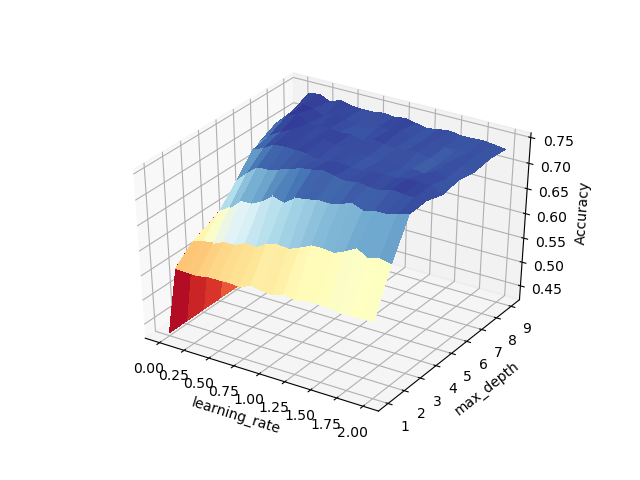

In [127]:
visualize(cmc_comb2, cmc_meshes, comb=2, dataset_type="class")

### Contraceptive Comb 2 - Zoom 1

In [67]:
generate_zoom(cmc_X, cmc_y, "./np_arrays/cmc_comb2.npy",
             cmc_meshes, "./np_arrays_50/cmc_comb2_zoom1.npy",
             zoom1=True, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.14393126, 0.18259936, 0.22126745, 0.25993555,
       0.29860365, 0.33727175, 0.37593985, 0.41460795, 0.45327605,
       0.49194415, 0.53061224, 0.56928034, 0.60794844, 0.64661654,
       0.68528464, 0.72395274, 0.76262084, 0.80128894, 0.83995704,
       0.87862513, 0.91729323, 0.95596133, 0.99462943, 1.03329753,
       1.07196563, 1.11063373, 1.14930183, 1.18796992, 1.22663802,
       1.26530612, 1.30397422, 1.34264232, 1.38131042, 1.41997852,
       1.45864662, 1.49731472, 1.53598281, 1.57465091, 1.61331901,
       1.65198711, 1.69065521, 1.72932331, 1.76799141, 1.80665951,
       1.8453276 , 1.8839957 , 1.9226638 , 1.9613319 , 2.        ]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8,
       8, 8, 8, 8, 8, 9]))


In [ ]:
'''
cmc_comb2_zoom1, cmc_comb2_zoom1_meshes = generate_zoom(cmc_X, cmc_y, "./np_arrays/cmc_comb2.npy",
             cmc_meshes, "./np_arrays_50/cmc_comb2_zoom1.npy",
             zoom1=True, save=True, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)
'''

In [64]:
cmc_comb2_zoom1, cmc_comb2_zoom1_meshes = np.load("./np_arrays_50/cmc_comb2_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


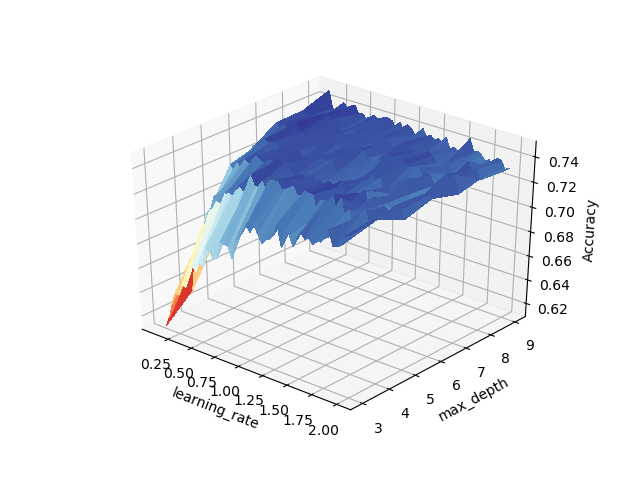

In [66]:
visualize(cmc_comb2_zoom1, cmc_comb2_zoom1_meshes, comb=2, dataset_type="class")

### Contraceptive Comb 2 - Zoom 2

In [68]:
generate_zoom(cmc_X, cmc_y, "./np_arrays_50/cmc_comb2_zoom1.npy",
             cmc_comb2_zoom1_meshes, "./np_arrays_50/cmc_comb2_zoom2.npy",
             zoom1=False, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.14393126, 0.18259936, 0.22126745, 0.25993555,
       0.29860365, 0.33727175, 0.37593985, 0.41460795, 0.45327605,
       0.49194415, 0.53061224, 0.56928034, 0.60794844, 0.64661654,
       0.68528464, 0.72395274, 0.76262084, 0.80128894, 0.83995704,
       0.87862513, 0.91729323, 0.95596133, 0.99462943, 1.03329753,
       1.07196563, 1.11063373, 1.14930183, 1.18796992, 1.22663802,
       1.26530612, 1.30397422, 1.34264232, 1.38131042, 1.41997852,
       1.45864662, 1.49731472, 1.53598281, 1.57465091, 1.61331901,
       1.65198711, 1.69065521, 1.72932331, 1.76799141, 1.80665951,
       1.8453276 , 1.8839957 , 1.9226638 , 1.9613319 , 2.        ]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8,
       8, 8, 8, 8, 8, 9]))


No difference.

## Contraceptive Comb 3

In [128]:
cmc_comb3 = generate_visualization(cmc_X, cmc_y, cmc_ranges, resolution=20, comb=3, dataset_type="class")

In [129]:
#np.save("./np_arrays/cmc_comb3.npy", cmc_comb3)

In [130]:
cmc_comb3 = np.load("./np_arrays/cmc_comb3.npy")

<IPython.core.display.Javascript object>


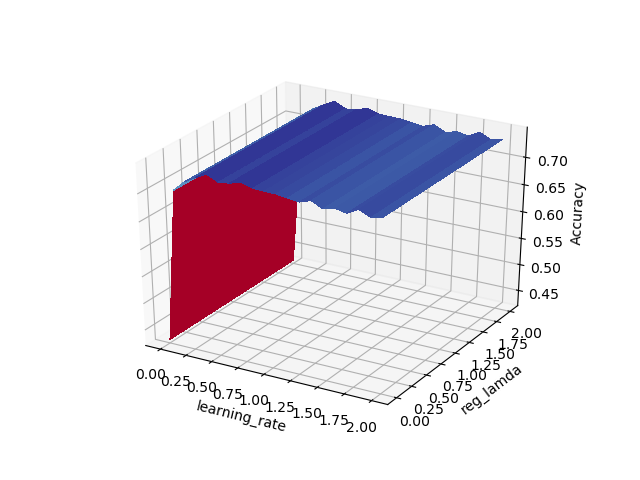

In [131]:
visualize(cmc_comb3, cmc_meshes, comb=3, dataset_type="class")

## Contraceptive Comb 4

In [141]:
cmc_comb4 = generate_visualization(cmc_X, cmc_y, cmc_ranges, resolution=20, comb=4, dataset_type="class")

In [142]:
#np.save("./np_arrays/cmc_comb4.npy", cmc_comb4)

In [143]:
cmc_comb4 = np.load("./np_arrays/cmc_comb4.npy")

<IPython.core.display.Javascript object>


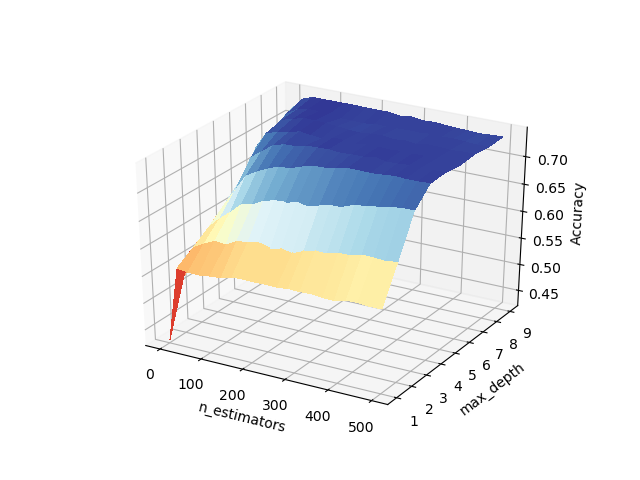

In [144]:
visualize(cmc_comb4, cmc_meshes, comb=4, dataset_type="class")

### Contraceptive Comb 4 - Zoom 1

In [12]:
generate_zoom(cmc_X, cmc_y, "./np_arrays/cmc_comb4.npy",
             cmc_meshes, "./np_arrays_50/cmc_comb4_zoom1.npy",
             zoom1=True, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]), array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 9]))


In [ ]:
'''
cmc_comb4_zoom1, cmc_comb4_zoom1_meshes = generate_zoom(cmc_X, cmc_y, "./np_arrays/cmc_comb4.npy",
             cmc_meshes, "./np_arrays_50/cmc_comb4_zoom1.npy",
             zoom1=True, save=True, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)
'''


In [11]:
cmc_comb4_zoom1, cmc_comb4_zoom1_meshes = np.load("./np_arrays_50/cmc_comb4_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


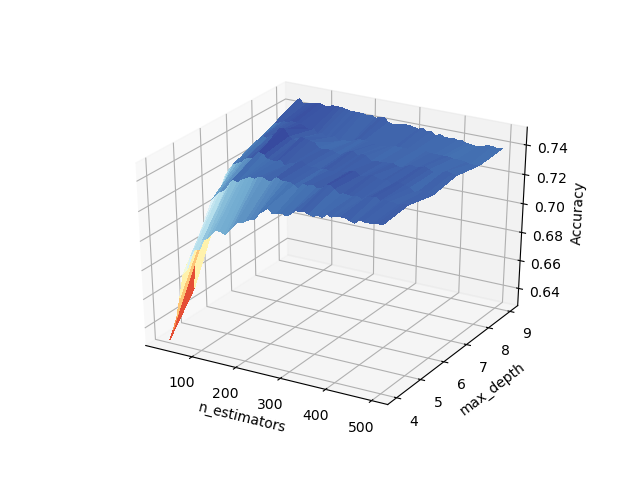

In [15]:
visualize(cmc_comb4_zoom1, cmc_comb4_zoom1_meshes, comb=4, dataset_type="class")

### Contraceptive Comb 4 - Zoom 2

In [17]:
generate_zoom(cmc_X, cmc_y, "./np_arrays_50/cmc_comb4_zoom1.npy",
             cmc_comb4_zoom1_meshes, "./np_arrays_50/cmc_comb4_zoom2.npy",
             zoom1=False, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([ 36,  45,  54,  64,  73,  83,  92, 102, 111, 121, 130, 140, 149,
       159, 168, 178, 187, 196, 206, 215, 225, 234, 244, 253, 263, 272,
       282, 291, 301, 310, 320, 329, 339, 348, 357, 367, 376, 386, 395,
       405, 414, 424, 433, 443, 452, 462, 471, 481, 490, 500]), array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 9]))


In [ ]:
'''
cmc_comb4_zoom2, cmc_comb4_zoom2_meshes = generate_zoom(cmc_X, cmc_y, "./np_arrays_50/cmc_comb4_zoom1.npy",
             cmc_comb4_zoom1_meshes, "./np_arrays_50/cmc_comb4_zoom2.npy",
             zoom1=False, save=True, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)
'''

In [12]:
cmc_comb4_zoom2, cmc_comb4_zoom2_meshes = np.load("./np_arrays_50/cmc_comb4_zoom2.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


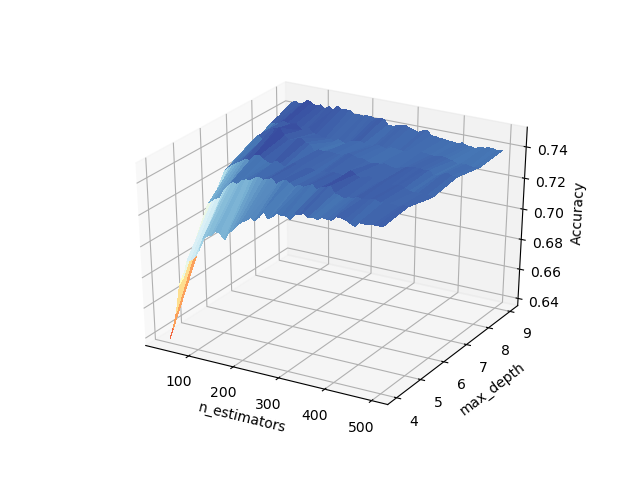

In [15]:
visualize(cmc_comb4_zoom2, cmc_comb4_zoom2_meshes, comb=4, dataset_type="class")

### Contraceptive Comb 4 - Zoom 3

In [16]:
generate_zoom(cmc_X, cmc_y, "./np_arrays_50/cmc_comb4_zoom2.npy",
             cmc_comb4_zoom2_meshes, "./np_arrays_50/cmc_comb4_zoom3.npy",
             zoom1=False, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([ 36,  45,  54,  64,  73,  83,  92, 102, 111, 121, 130, 140, 149,
       159, 168, 178, 187, 196, 206, 215, 225, 234, 244, 253, 263, 272,
       282, 291, 301, 310, 320, 329, 339, 348, 357, 367, 376, 386, 395,
       405, 414, 424, 433, 443, 452, 462, 471, 481, 490, 500]), array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 9]))


No difference.

## Contraceptive Comb 5

In [145]:
cmc_comb5 = generate_visualization(cmc_X, cmc_y, cmc_ranges, resolution=20, comb=5, dataset_type="class")

In [146]:
#np.save("./np_arrays/cmc_comb5.npy", cmc_comb5)

In [147]:
cmc_comb5 = np.load("./np_arrays/cmc_comb5.npy")

<IPython.core.display.Javascript object>


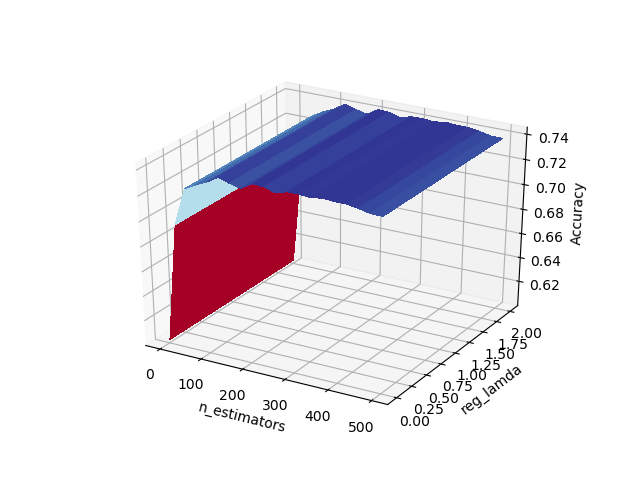

In [148]:
visualize(cmc_comb5, cmc_meshes, comb=5, dataset_type="class")

## Contraceptive Comb 6

In [134]:
cmc_comb6 = generate_visualization(cmc_X, cmc_y, cmc_ranges, resolution=20, comb=6, dataset_type="class")

In [149]:
#np.save("./np_arrays/cmc_comb6.npy", cmc_comb6)

In [150]:
cmc_comb6 = np.load("./np_arrays/cmc_comb6.npy")

<IPython.core.display.Javascript object>


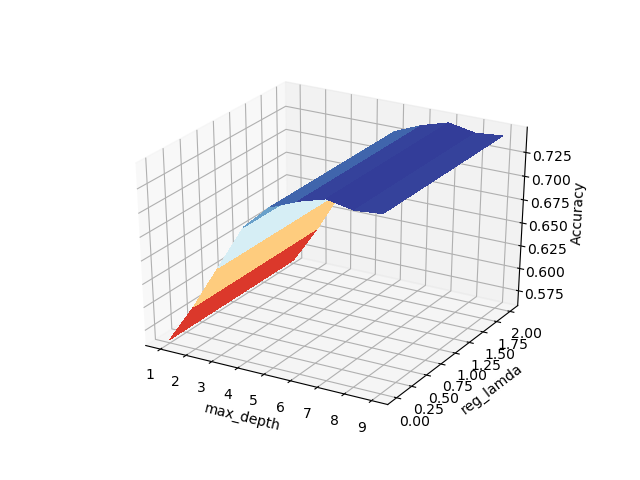

In [151]:
visualize(cmc_comb6, cmc_meshes, comb=6, dataset_type="class")

# Winequality-red

In [18]:
winer = pd.read_csv("winer_shuffled.csv")
winer_X = winer.drop(["quality"], axis=1)
winer_y = winer["quality"]

In [19]:
winer_learning_rate = np.linspace(0.0,2.0,20)
winer_n_estimators = np.linspace(1,500,20, dtype=int)
winer_max_depth = np.linspace(1,11,20, dtype=int)
winer_reg_lamda = np.linspace(0.0, 2.0, 20)

winer_ranges = (winer_learning_rate, winer_n_estimators, winer_max_depth, winer_reg_lamda)

In [20]:
winer_meshes = generate_meshgrids(winer_ranges)

## Winequality-red Comb 1

In [166]:
#cmc_comb6 = generate_visualization(cmc_X, cmc_y, cmc_ranges, resolution=20, comb=6, dataset_type="class")
winer_comb1 = generate_visualization(winer_X, winer_y, winer_ranges, resolution=20, comb=1, dataset_type="class")

In [167]:
#np.save("./np_arrays/winer_comb1.npy", winer_comb1)

In [171]:
winer_comb1 = np.load("./np_arrays/winer_comb1.npy")

c:\users\ole-edvard ørebæk\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


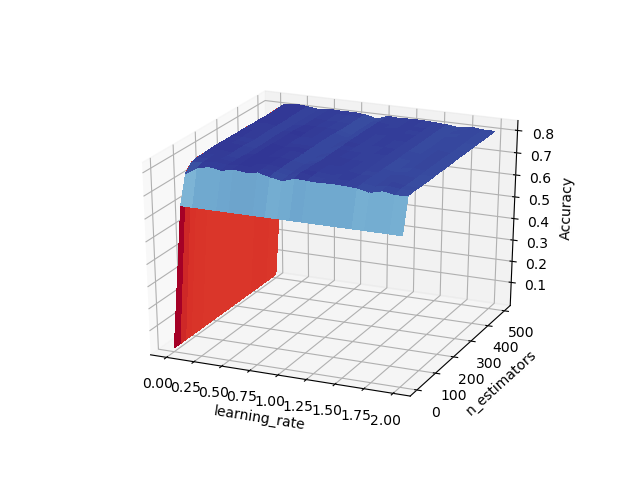

In [172]:
visualize(winer_comb1, winer_meshes, comb=1, dataset_type="class")

### Winequality-red Comb 1 - Zoom 1

In [21]:
generate_zoom(winer_X, winer_y, "./np_arrays/winer_comb1.npy",
             winer_meshes, "./np_arrays_50/winer_comb1_zoom1.npy",
             zoom1=True, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.1396348 , 0.17400644, 0.20837809, 0.24274973,
       0.27712137, 0.31149302, 0.34586466, 0.38023631, 0.41460795,
       0.44897959, 0.48335124, 0.51772288, 0.55209452, 0.58646617,
       0.62083781, 0.65520945, 0.6895811 , 0.72395274, 0.75832438,
       0.79269603, 0.82706767, 0.86143931, 0.89581096, 0.9301826 ,
       0.96455424, 0.99892589, 1.03329753, 1.06766917, 1.10204082,
       1.13641246, 1.1707841 , 1.20515575, 1.23952739, 1.27389903,
       1.30827068, 1.34264232, 1.37701396, 1.41138561, 1.44575725,
       1.48012889, 1.51450054, 1.54887218, 1.58324382, 1.61761547,
       1.65198711, 1.68635875, 1.7207304 , 1.75510204, 1.78947368]), array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]))


In [ ]:
'''
winer_comb1_zoom1, winer_comb1_zoom1_meshes = generate_zoom(winer_X, winer_y, "./np_arrays/winer_comb1.npy",
             winer_meshes, "./np_arrays_50/winer_comb1_zoom1.npy",
             zoom1=True, save=True, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)
'''


In [22]:
winer_comb1_zoom1, winer_comb1_zoom1_meshes = np.load("./np_arrays_50/winer_comb1_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


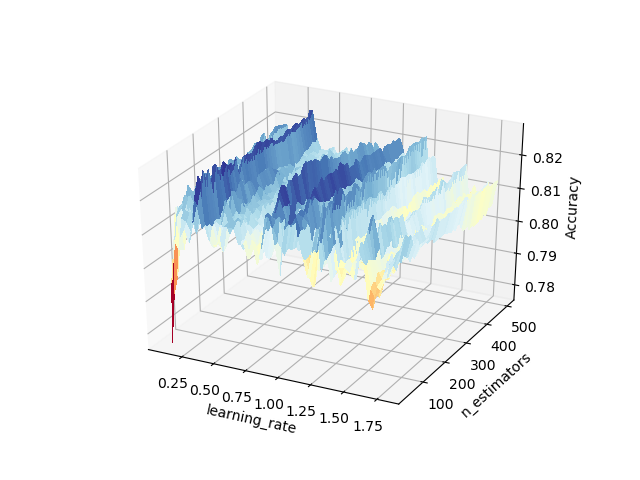

In [23]:
visualize(winer_comb1_zoom1, winer_comb1_zoom1_meshes, comb=1, dataset_type="class")

### Winequality-red Comb 1 - Zoom 2

In [24]:
generate_zoom(winer_X, winer_y, "./np_arrays_50/winer_comb1_zoom1.npy",
             winer_comb1_zoom1_meshes, "np_arrays_50/winer_comb1_zoom2.npy",
             zoom1=False, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.1396348 , 0.17400644, 0.20837809, 0.24274973,
       0.27712137, 0.31149302, 0.34586466, 0.38023631, 0.41460795,
       0.44897959, 0.48335124, 0.51772288, 0.55209452, 0.58646617,
       0.62083781, 0.65520945, 0.6895811 , 0.72395274, 0.75832438,
       0.79269603, 0.82706767, 0.86143931, 0.89581096, 0.9301826 ,
       0.96455424, 0.99892589, 1.03329753, 1.06766917, 1.10204082,
       1.13641246, 1.1707841 , 1.20515575, 1.23952739, 1.27389903,
       1.30827068, 1.34264232, 1.37701396, 1.41138561, 1.44575725,
       1.48012889, 1.51450054, 1.54887218, 1.58324382, 1.61761547,
       1.65198711, 1.68635875, 1.7207304 , 1.75510204, 1.78947368]), array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]))


No difference.

## Winequality-red Comb 2

In [173]:
winer_comb2 = generate_visualization(winer_X, winer_y, winer_ranges, resolution=20, comb=2, dataset_type="class")

In [174]:
#np.save("./np_arrays/winer_comb2.npy", winer_comb2)

In [175]:
winer_comb2 = np.load("./np_arrays/winer_comb2.npy")

c:\users\ole-edvard ørebæk\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


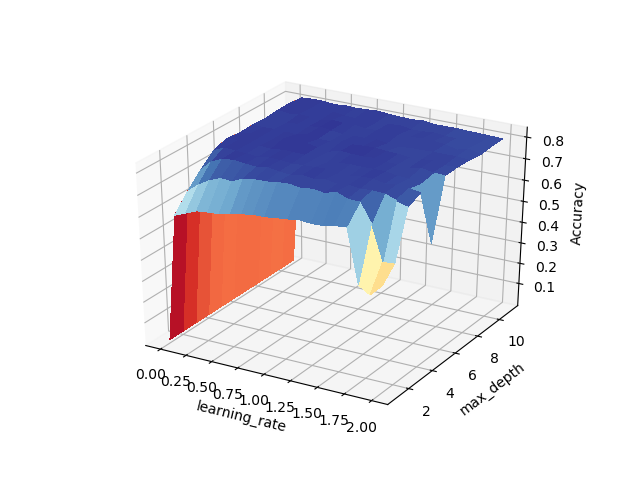

In [176]:
visualize(winer_comb2, winer_meshes, comb=2, dataset_type="class")

### Winequality-red Comb 2 - Zoom 1

In [26]:
generate_zoom(winer_X, winer_y, "./np_arrays/winer_comb2.npy",
             winer_meshes, "./np_arrays_50/winer_comb2_zoom1.npy",
             zoom1=True, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.14178303, 0.1783029 , 0.21482277, 0.25134264,
       0.28786251, 0.32438238, 0.36090226, 0.39742213, 0.433942  ,
       0.47046187, 0.50698174, 0.54350161, 0.58002148, 0.61654135,
       0.65306122, 0.6895811 , 0.72610097, 0.76262084, 0.79914071,
       0.83566058, 0.87218045, 0.90870032, 0.94522019, 0.98174006,
       1.01825994, 1.05477981, 1.09129968, 1.12781955, 1.16433942,
       1.20085929, 1.23737916, 1.27389903, 1.3104189 , 1.34693878,
       1.38345865, 1.41997852, 1.45649839, 1.49301826, 1.52953813,
       1.566058  , 1.60257787, 1.63909774, 1.67561762, 1.71213749,
       1.74865736, 1.78517723, 1.8216971 , 1.85821697, 1.89473684]), array([ 2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11]))


In [ ]:
'''
winer_comb2_zoom1, winer_comb2_zoom1_meshes = generate_zoom(winer_X, winer_y, "./np_arrays/winer_comb2.npy",
             winer_meshes, "./np_arrays_50/winer_comb2_zoom1.npy",
             zoom1=True, save=True, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)
'''


In [27]:
winer_comb2_zoom1, winer_comb2_zoom1_meshes = np.load("./np_arrays_50/winer_comb2_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


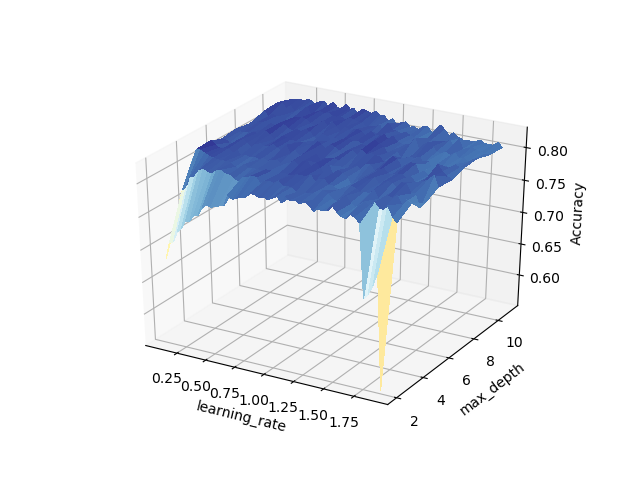

In [28]:
visualize(winer_comb2_zoom1, winer_comb2_zoom1_meshes, comb=2, dataset_type="class")

### Winequality-red Comb 2 - Zoom 2

In [29]:
generate_zoom(winer_X, winer_y, "./np_arrays_50/winer_comb2_zoom1.npy",
             winer_comb2_zoom1_meshes, "./np_arrays_50/winer_comb2_zoom2.npy",
             zoom1=False, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([0.10526316, 0.14103773, 0.17681229, 0.21258686, 0.24836143,
       0.284136  , 0.31991056, 0.35568513, 0.3914597 , 0.42723427,
       0.46300883, 0.4987834 , 0.53455797, 0.57033254, 0.6061071 ,
       0.64188167, 0.67765624, 0.71343081, 0.74920537, 0.78497994,
       0.82075451, 0.85652908, 0.89230365, 0.92807821, 0.96385278,
       0.99962735, 1.03540192, 1.07117648, 1.10695105, 1.14272562,
       1.17850019, 1.21427475, 1.25004932, 1.28582389, 1.32159846,
       1.35737302, 1.39314759, 1.42892216, 1.46469673, 1.50047129,
       1.53624586, 1.57202043, 1.607795  , 1.64356957, 1.67934413,
       1.7151187 , 1.75089327, 1.78666784, 1.8224424 , 1.85821697]), array([ 2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11]))


In [ ]:
winer_comb2_zoom2, winer_comb2_zoom2_meshes = generate_zoom(winer_X, winer_y, "./np_arrays_50/winer_comb2_zoom1.npy",
             winer_comb2_zoom1_meshes, "./np_arrays_50/winer_comb2_zoom2.npy",
             zoom1=False, save=True, comb=2, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)

In [ ]:
winer_comb2_zoom2, winer_comb2_zoom2_meshes = np.load("./np_arrays_50/winer_comb2_zoom2.npy", allow_pickle=True)

In [ ]:
visualize(winer_comb2_zoom2, winer_comb2_zoom2_meshes, comb=2, dataset_type="class")

## Winequality-red Comb 3

In [48]:
winer_comb3 = generate_visualization(winer_X, winer_y, winer_ranges, resolution=20, comb=3, dataset_type="class")

In [49]:
#np.save("./np_arrays/winer_comb3.npy", winer_comb3)

In [50]:
winer_comb3 = np.load("./np_arrays/winer_comb3.npy")

<IPython.core.display.Javascript object>


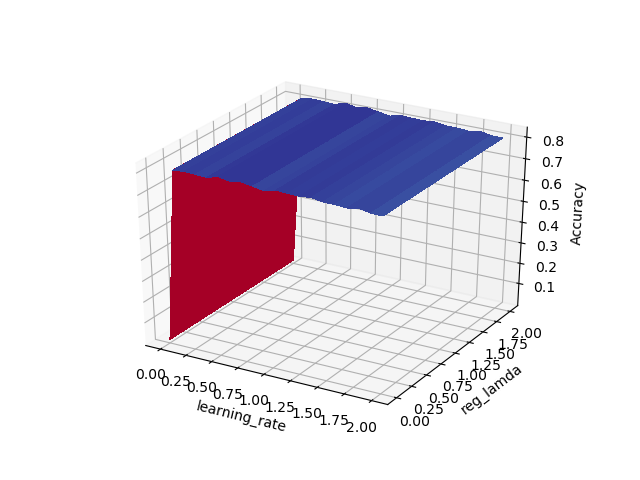

In [51]:
visualize(winer_comb3, winer_meshes, comb=3, dataset_type="class")

### Winequality-red Comb 3 - Zoom 1 (Unneccessary)

In [ ]:
'''
generate_zoom(winer_X, winer_y, "./np_arrays/winer_comb3.npy",
             winer_meshes, "./np_arrays_50/winer_comb3_zoom1.npy",
             zoom1=True, save=False, comb=3, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)
'''


In [ ]:
'''
winer_comb3_zoom1, winer_comb3_zoom1_meshes =  generate_zoom(winer_X, winer_y, "./np_arrays/winer_comb3.npy",
             winer_meshes, "./np_arrays_50/winer_comb3_zoom1.npy",
             zoom1=True, save=True, comb=3, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)
'''


In [ ]:
#winer_comb3_zoom1, winer_comb3_zoom1_meshes = np.load("./np_arrays_50/winer_comb3_zoom1.npy", allow_pickle=True)

In [ ]:
#visualize(winer_comb3_zoom1, winer_comb3_zoom1_meshes, comb=3, dataset_type="class")

## Winequality-red Comb 4

In [52]:
winer_comb4 = generate_visualization(winer_X, winer_y, winer_ranges, resolution=20, comb=4, dataset_type="class")

In [53]:
#np.save("./np_arrays/winer_comb4.npy", winer_comb4)

In [54]:
winer_comb4 = np.load("./np_arrays/winer_comb4.npy")

<IPython.core.display.Javascript object>


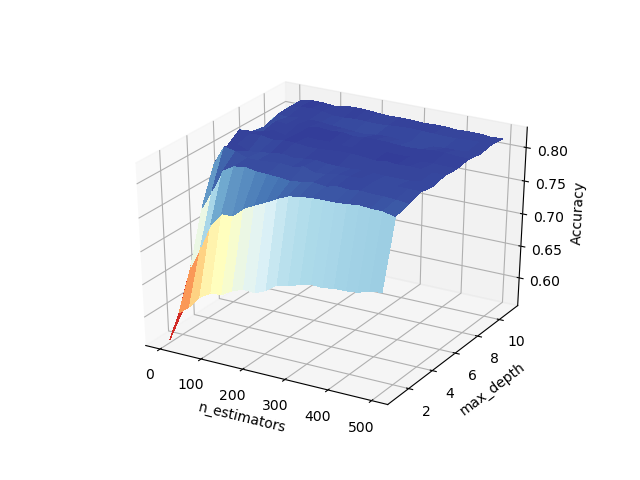

In [55]:
visualize(winer_comb4, winer_meshes, comb=4, dataset_type="class")

### Winequality-red Comb 4 - Zoom 1

In [30]:
generate_zoom(winer_X, winer_y, "./np_arrays/winer_comb4.npy",
             winer_meshes, "./np_arrays_50/winer_comb4_zoom1.npy",
             zoom1=True, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]), array([ 3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11]))


In [ ]:
'''
winer_comb4_zoom1, winer_comb4_zoom1_meshes = generate_zoom(winer_X, winer_y, "./np_arrays/winer_comb4.npy",
             winer_meshes, "./np_arrays_50/winer_comb4_zoom1.npy",
             zoom1=True, save=True, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=False)
'''

In [31]:
winer_comb4_zoom1, winer_comb4_zoom1_meshes = np.load("./np_arrays_50/winer_comb4_zoom1.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


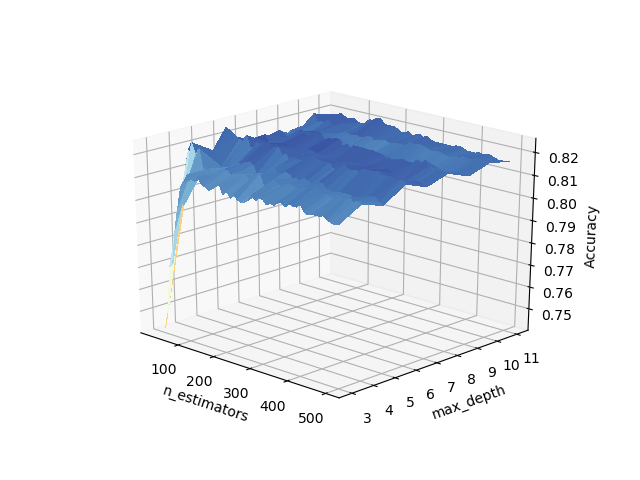

In [32]:
visualize(winer_comb4_zoom1, winer_comb4_zoom1_meshes, comb=4, dataset_type="class")

### Winequality-red Comb 4 - Zoom 2

In [33]:
generate_zoom(winer_X, winer_y, "./np_arrays_50/winer_comb4_zoom1.npy",
             winer_comb4_zoom1_meshes, "./np_arrays_50/winer_comb4_zoom2.npy",
             zoom1=False, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)

(array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]), array([ 4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
        8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 11]))


Basically no change.

## Winequality-red Comb 5

In [56]:
winer_comb5 = generate_visualization(winer_X, winer_y, winer_ranges, resolution=20, comb=5, dataset_type="class")

In [57]:
#np.save("./np_arrays/winer_comb5.npy", winer_comb5)

In [58]:
winer_comb5 = np.load("./np_arrays/winer_comb5.npy")

<IPython.core.display.Javascript object>


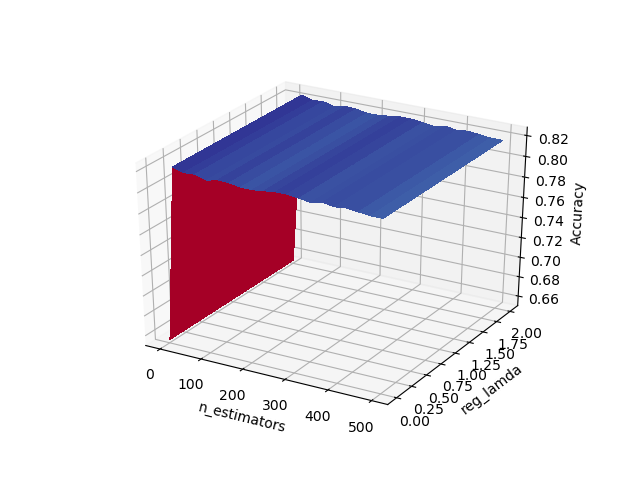

In [59]:
visualize(winer_comb5, winer_meshes, comb=5, dataset_type="class")

## Winequality-red Comb 6

In [60]:
winer_comb6 = generate_visualization(winer_X, winer_y, winer_ranges, resolution=20, comb=6, dataset_type="class")

In [61]:
#np.save("./np_arrays/winer_comb6.npy", winer_comb6)

In [62]:
winer_comb6 = np.load("./np_arrays/winer_comb6.npy")

<IPython.core.display.Javascript object>


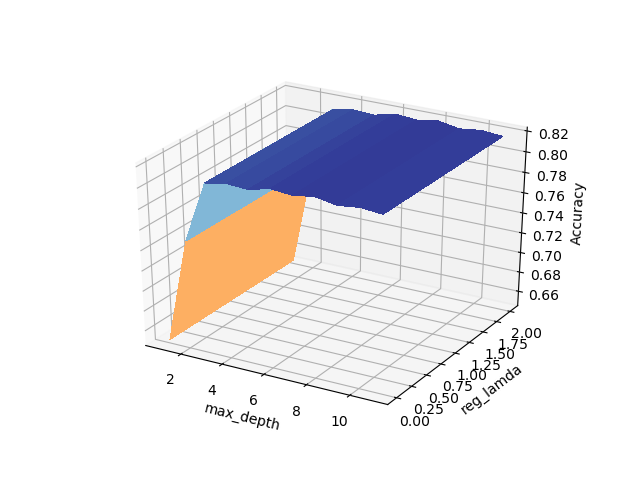

In [63]:
visualize(winer_comb6, winer_meshes, comb=6, dataset_type="class")

# auto-mpg

In [11]:
auto = pd.read_csv("auto_mpg_pp.csv")
auto_X = auto.drop(["0"], axis=1)
auto_y = auto["0"]

In [12]:

auto_learning_rate = np.linspace(0.0,2.0,20)
auto_n_estimators = np.linspace(1,500,20, dtype=int)
auto_max_depth = np.linspace(1, 7, 20, dtype=int)
auto_reg_lamda = np.linspace(0.0, 2.0, 20)

auto_ranges = (auto_learning_rate, auto_n_estimators, auto_max_depth, auto_reg_lamda)

In [13]:
#winer_meshes = generate_meshgrids(winer_ranges)
auto_meshes = generate_meshgrids(auto_ranges)

## auto-mpg Comb 1

In [14]:
auto_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       398 non-null    int64  
 1   2       398 non-null    float64
 2   3       392 non-null    float64
 3   4       398 non-null    float64
 4   5       398 non-null    float64
 5   6       398 non-null    int64  
 6   7       398 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 21.9 KB


In [15]:

auto_comb1 = generate_visualization(auto_X, auto_y, auto_ranges, resolution=20, comb=1, dataset_type="reg")

In [16]:

#np.save("./np_arrays/auto_comb1.npy", auto_comb1)

In [17]:
auto_comb1 = np.load("./np_arrays/auto_comb1.npy")

In [19]:
auto_comb1 = 0 - auto_comb1

<IPython.core.display.Javascript object>


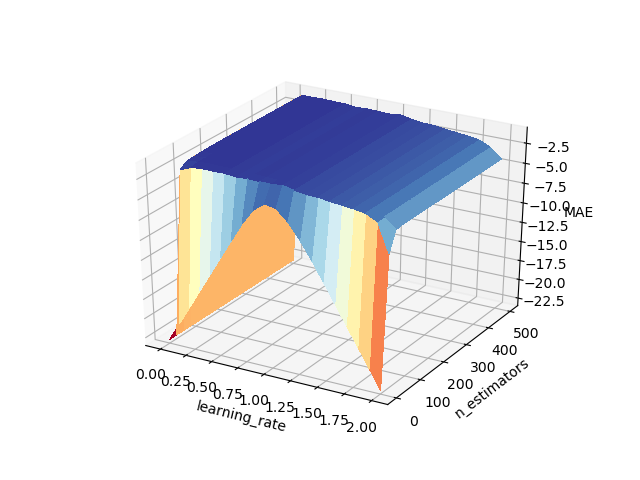

In [20]:
#visualize(winer_comb6, winer_meshes, comb=6, dataset_type="class")
visualize(auto_comb1, auto_meshes, comb=1, dataset_type="reg")

### auto-mpg Comb 1 Zoom 1

In [48]:

generate_zoom(auto_X, auto_y, "./np_arrays/auto_comb1.npy",
             auto_meshes, "./np_arrays_50/auto_comb1_zoom1.npy",
             zoom1=True, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.10526316, 0.12674544, 0.14822771, 0.16970999, 0.19119227,
       0.21267454, 0.23415682, 0.2556391 , 0.27712137, 0.29860365,
       0.32008593, 0.34156821, 0.36305048, 0.38453276, 0.40601504,
       0.42749731, 0.44897959, 0.47046187, 0.49194415, 0.51342642,
       0.5349087 , 0.55639098, 0.57787325, 0.59935553, 0.62083781,
       0.64232009, 0.66380236, 0.68528464, 0.70676692, 0.72824919,
       0.74973147, 0.77121375, 0.79269603, 0.8141783 , 0.83566058,
       0.85714286, 0.87862513, 0.90010741, 0.92158969, 0.94307197,
       0.96455424, 0.98603652, 1.0075188 , 1.02900107, 1.05048335,
       1.07196563, 1.09344791, 1.11493018, 1.13641246, 1.15789474]), array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]))


In [49]:
'''
generate_zoom(auto_X, auto_y, "./np_arrays/auto_comb1.npy",
             auto_meshes, "./np_arrays_50/auto_comb1_zoom1.npy",
             zoom1=True, save=True, comb=1, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''

(array([[1.80002421, 1.49716751, 1.36277481, ..., 1.28502745, 1.42025429,
         1.42539949],
        [1.42914801, 1.30080954, 1.24154974, ..., 1.28396624, 1.41997394,
         1.42526382],
        [1.28796514, 1.20568794, 1.18423738, ..., 1.28395205, 1.41997393,
         1.42526382],
        ...,
        [1.03074108, 1.01061863, 1.02958497, ..., 1.28395205, 1.41997341,
         1.42526382],
        [1.03074108, 1.01061863, 1.02958497, ..., 1.28395205, 1.41997339,
         1.42526382],
        [1.03074108, 1.01061863, 1.02958497, ..., 1.28395205, 1.41997338,
         1.42526382]]),
 ((array([[0.10526316, 0.12674544, 0.14822771, ..., 1.11493018, 1.13641246,
           1.15789474],
          [0.10526316, 0.12674544, 0.14822771, ..., 1.11493018, 1.13641246,
           1.15789474],
          [0.10526316, 0.12674544, 0.14822771, ..., 1.11493018, 1.13641246,
           1.15789474],
          ...,
          [0.10526316, 0.12674544, 0.14822771, ..., 1.11493018, 1.13641246,
           1.15789

In [50]:

auto_comb1_zoom1, auto_comb1_zoom1_meshes = np.load("./np_arrays_50/auto_comb1_zoom1.npy", allow_pickle=True)

In [52]:
auto_comb1_zoom1 = 0 - auto_comb1_zoom1

<IPython.core.display.Javascript object>


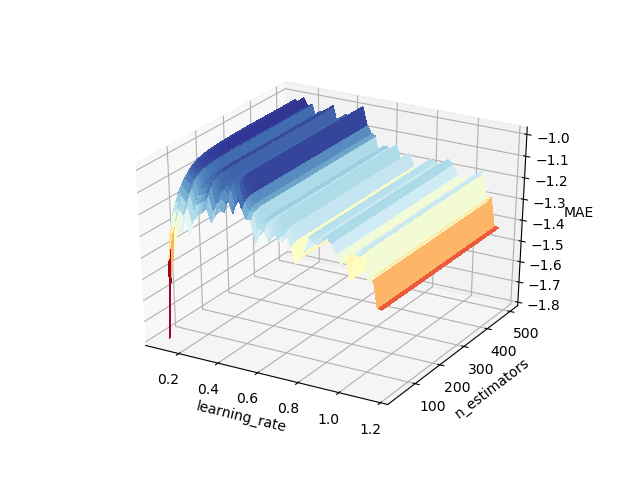

In [53]:

visualize(auto_comb1_zoom1, auto_comb1_zoom1_meshes, comb=1, dataset_type="reg")

### auto-mpg Comb 1 Zoom 2

In [55]:
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb1_zoom1.npy",
             auto_comb1_zoom1_meshes, "./np_arrays_50/auto_comb1_zoom2.npy",
             zoom1=False, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.10526316, 0.12148447, 0.13770578, 0.15392709, 0.1701484 ,
       0.18636971, 0.20259103, 0.21881234, 0.23503365, 0.25125496,
       0.26747627, 0.28369758, 0.29991889, 0.3161402 , 0.33236152,
       0.34858283, 0.36480414, 0.38102545, 0.39724676, 0.41346807,
       0.42968938, 0.4459107 , 0.46213201, 0.47835332, 0.49457463,
       0.51079594, 0.52701725, 0.54323856, 0.55945987, 0.57568119,
       0.5919025 , 0.60812381, 0.62434512, 0.64056643, 0.65678774,
       0.67300905, 0.68923036, 0.70545168, 0.72167299, 0.7378943 ,
       0.75411561, 0.77033692, 0.78655823, 0.80277954, 0.81900085,
       0.83522217, 0.85144348, 0.86766479, 0.8838861 , 0.90010741]), array([ 27,  36,  46,  55,  65,  75,  84,  94, 104, 113, 123, 133, 142,
       152, 162, 171, 181, 191, 200, 210, 220, 229, 239, 249, 258, 268,
       277, 287, 297, 306, 316, 326, 335, 345, 355, 364, 374, 384, 393,
       403, 413, 422, 432, 442, 451, 461, 471, 480, 490, 500]))


In [56]:
'''
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb1_zoom1.npy",
             auto_comb1_zoom1_meshes, "./np_arrays_50/auto_comb1_zoom2.npy",
             zoom1=False, save=True, comb=1, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''

(array([[1.80002421, 1.5583348 , 1.43104642, ..., 1.17513598, 1.11873203,
         1.15484476],
        [1.42914801, 1.32467176, 1.30863366, ..., 1.17239888, 1.11639862,
         1.15322515],
        [1.28796514, 1.22547653, 1.24830127, ..., 1.17212145, 1.11625895,
         1.15317323],
        ...,
        [1.03074108, 1.00291225, 1.0685878 , ..., 1.17212145, 1.11625895,
         1.15317323],
        [1.03074108, 1.00291225, 1.0685878 , ..., 1.17212145, 1.11625895,
         1.15317323],
        [1.03074108, 1.00291225, 1.0685878 , ..., 1.17212145, 1.11625895,
         1.15317323]]),
 ((array([[0.10526316, 0.12148447, 0.13770578, ..., 0.86766479, 0.8838861 ,
           0.90010741],
          [0.10526316, 0.12148447, 0.13770578, ..., 0.86766479, 0.8838861 ,
           0.90010741],
          [0.10526316, 0.12148447, 0.13770578, ..., 0.86766479, 0.8838861 ,
           0.90010741],
          ...,
          [0.10526316, 0.12148447, 0.13770578, ..., 0.86766479, 0.8838861 ,
           0.90010

In [57]:
auto_comb1_zoom2, auto_comb1_zoom2_meshes = np.load("./np_arrays_50/auto_comb1_zoom2.npy", allow_pickle=True)

In [58]:
auto_comb1_zoom2 = 0 - auto_comb1_zoom2

<IPython.core.display.Javascript object>


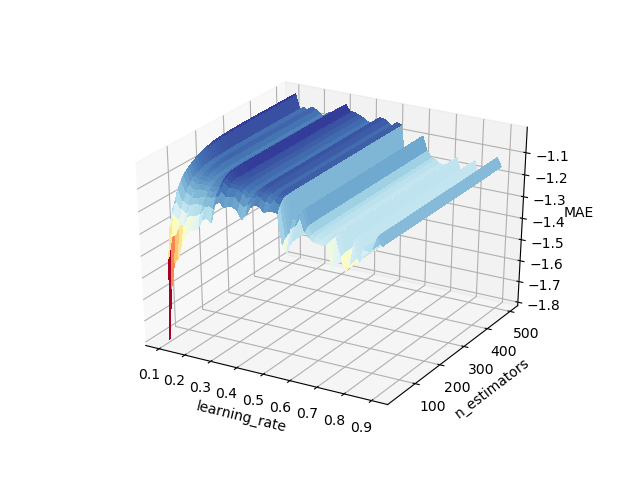

In [59]:
visualize(auto_comb1_zoom2, auto_comb1_zoom2_meshes, comb=1, dataset_type="reg")

### auto-mpg Comb 1 Zoom 3

In [60]:
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb1_zoom2.npy",
             auto_comb1_zoom2_meshes, "./np_arrays_50/auto_comb1_zoom3.npy",
             zoom1=False, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.10526316, 0.11552562, 0.12578808, 0.13605054, 0.14631301,
       0.15657547, 0.16683793, 0.17710039, 0.18736286, 0.19762532,
       0.20788778, 0.21815024, 0.2284127 , 0.23867517, 0.24893763,
       0.25920009, 0.26946255, 0.27972502, 0.28998748, 0.30024994,
       0.3105124 , 0.32077487, 0.33103733, 0.34129979, 0.35156225,
       0.36182471, 0.37208718, 0.38234964, 0.3926121 , 0.40287456,
       0.41313703, 0.42339949, 0.43366195, 0.44392441, 0.45418687,
       0.46444934, 0.4747118 , 0.48497426, 0.49523672, 0.50549919,
       0.51576165, 0.52602411, 0.53628657, 0.54654903, 0.5568115 ,
       0.56707396, 0.57733642, 0.58759888, 0.59786135, 0.60812381]), array([ 36,  45,  54,  64,  73,  83,  92, 102, 111, 121, 130, 140, 149,
       159, 168, 178, 187, 196, 206, 215, 225, 234, 244, 253, 263, 272,
       282, 291, 301, 310, 320, 329, 339, 348, 357, 367, 376, 386, 395,
       405, 414, 424, 433, 443, 452, 462, 471, 481, 490, 500]))


In [61]:
'''
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb1_zoom2.npy",
             auto_comb1_zoom2_meshes, "./np_arrays_50/auto_comb1_zoom3.npy",
             zoom1=False, save=True, comb=1, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''

(array([[1.42914801, 1.36177869, 1.32184641, ..., 1.08986393, 1.11741482,
         1.08985305],
        [1.29726788, 1.24331504, 1.24828501, ..., 1.08468499, 1.11134778,
         1.08579676],
        [1.23654417, 1.19239672, 1.2203083 , ..., 1.0832239 , 1.10835162,
         1.08482231],
        ...,
        [1.03074108, 1.01344935, 1.07067116, ..., 1.08278407, 1.10714159,
         1.08454729],
        [1.03074108, 1.01344935, 1.07067116, ..., 1.08278407, 1.10714159,
         1.08454729],
        [1.03074108, 1.01344935, 1.07067116, ..., 1.08278407, 1.10714159,
         1.08454729]]),
 ((array([[0.10526316, 0.11552562, 0.12578808, ..., 0.58759888, 0.59786135,
           0.60812381],
          [0.10526316, 0.11552562, 0.12578808, ..., 0.58759888, 0.59786135,
           0.60812381],
          [0.10526316, 0.11552562, 0.12578808, ..., 0.58759888, 0.59786135,
           0.60812381],
          ...,
          [0.10526316, 0.11552562, 0.12578808, ..., 0.58759888, 0.59786135,
           0.60812

In [62]:
auto_comb1_zoom3, auto_comb1_zoom3_meshes = np.load("./np_arrays_50/auto_comb1_zoom3.npy", allow_pickle=True)

In [63]:
auto_comb1_zoom3 = 0 - auto_comb1_zoom3

<IPython.core.display.Javascript object>


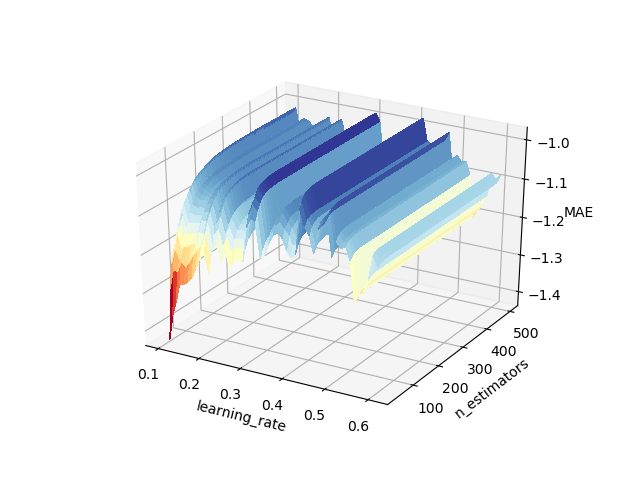

In [64]:
visualize(auto_comb1_zoom3, auto_comb1_zoom3_meshes, comb=1, dataset_type="reg")

### auto-mpg Comb 1 Zoom 4

In [65]:
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb1_zoom3.npy",
             auto_comb1_zoom3_meshes, "./np_arrays_50/auto_comb1_zoom4.npy",
             zoom1=False, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.10526316, 0.11385012, 0.12243707, 0.13102403, 0.13961099,
       0.14819795, 0.15678491, 0.16537187, 0.17395882, 0.18254578,
       0.19113274, 0.1997197 , 0.20830666, 0.21689361, 0.22548057,
       0.23406753, 0.24265449, 0.25124145, 0.25982841, 0.26841536,
       0.27700232, 0.28558928, 0.29417624, 0.3027632 , 0.31135015,
       0.31993711, 0.32852407, 0.33711103, 0.34569799, 0.35428495,
       0.3628719 , 0.37145886, 0.38004582, 0.38863278, 0.39721974,
       0.4058067 , 0.41439365, 0.42298061, 0.43156757, 0.44015453,
       0.44874149, 0.45732844, 0.4659154 , 0.47450236, 0.48308932,
       0.49167628, 0.50026324, 0.50885019, 0.51743715, 0.52602411]), array([ 36,  45,  54,  64,  73,  83,  92, 102, 111, 121, 130, 140, 149,
       159, 168, 178, 187, 196, 206, 215, 225, 234, 244, 253, 263, 272,
       282, 291, 301, 310, 320, 329, 339, 348, 357, 367, 376, 386, 395,
       405, 414, 424, 433, 443, 452, 462, 471, 481, 490, 500]))


In [66]:
'''
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb1_zoom3.npy",
             auto_comb1_zoom3_meshes, "./np_arrays_50/auto_comb1_zoom4.npy",
             zoom1=False, save=True, comb=1, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''

(array([[1.42914801, 1.34674541, 1.29735645, ..., 1.04704476, 1.0688109 ,
         1.08301474],
        [1.29726788, 1.26269723, 1.21845025, ..., 1.03356242, 1.05758656,
         1.07536443],
        [1.23654417, 1.21437303, 1.17247909, ..., 1.02855646, 1.05409495,
         1.06941936],
        ...,
        [1.03074108, 1.0270144 , 1.00517727, ..., 1.02567983, 1.05110397,
         1.06607873],
        [1.03074108, 1.0270144 , 1.00517727, ..., 1.02567982, 1.05110397,
         1.06607873],
        [1.03074108, 1.0270144 , 1.00517727, ..., 1.02567981, 1.05110397,
         1.06607873]]),
 ((array([[0.10526316, 0.11385012, 0.12243707, ..., 0.50885019, 0.51743715,
           0.52602411],
          [0.10526316, 0.11385012, 0.12243707, ..., 0.50885019, 0.51743715,
           0.52602411],
          [0.10526316, 0.11385012, 0.12243707, ..., 0.50885019, 0.51743715,
           0.52602411],
          ...,
          [0.10526316, 0.11385012, 0.12243707, ..., 0.50885019, 0.51743715,
           0.52602

In [67]:
auto_comb1_zoom4, auto_comb1_zoom4_meshes = np.load("./np_arrays_50/auto_comb1_zoom4.npy", allow_pickle=True)

In [68]:
auto_comb1_zoom4 = 0 - auto_comb1_zoom4

<IPython.core.display.Javascript object>


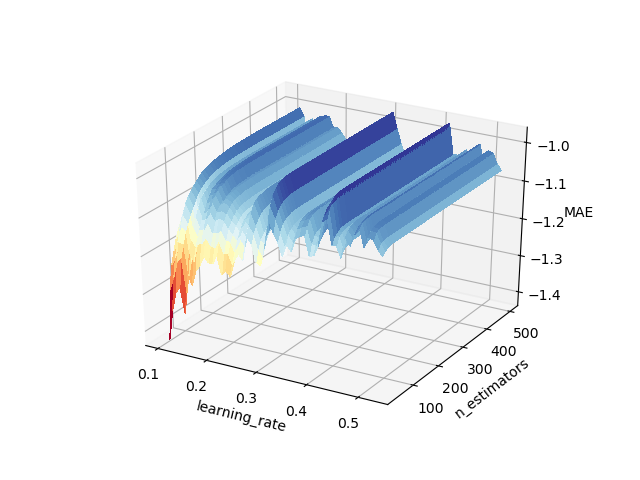

In [69]:
visualize(auto_comb1_zoom4, auto_comb1_zoom4_meshes, comb=1, dataset_type="reg")

### auto-mpg Comb 1 Zoom 5

In [70]:
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb1_zoom4.npy",
             auto_comb1_zoom4_meshes, "./np_arrays_50/auto_comb1_zoom5.npy",
             zoom1=False, save=False, comb=1, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.10526316, 0.11349963, 0.1217361 , 0.12997257, 0.13820904,
       0.14644551, 0.15468198, 0.16291845, 0.17115492, 0.17939139,
       0.18762786, 0.19586433, 0.2041008 , 0.21233727, 0.22057374,
       0.22881021, 0.23704668, 0.24528315, 0.25351962, 0.26175609,
       0.26999256, 0.27822903, 0.2864655 , 0.29470197, 0.30293844,
       0.31117491, 0.31941138, 0.32764785, 0.33588432, 0.34412079,
       0.35235726, 0.36059373, 0.3688302 , 0.37706667, 0.38530314,
       0.39353961, 0.40177608, 0.41001255, 0.41824902, 0.42648549,
       0.43472196, 0.44295843, 0.4511949 , 0.45943137, 0.46766784,
       0.47590431, 0.48414078, 0.49237725, 0.50061372, 0.50885019]), array([ 36,  45,  54,  64,  73,  83,  92, 102, 111, 121, 130, 140, 149,
       159, 168, 178, 187, 196, 206, 215, 225, 234, 244, 253, 263, 272,
       282, 291, 301, 310, 320, 329, 339, 348, 357, 367, 376, 386, 395,
       405, 414, 424, 433, 443, 452, 462, 471, 481, 490, 500]))


No significant difference

## auto-mpg Comb 2

In [21]:
auto_comb2 = generate_visualization(auto_X, auto_y, auto_ranges, resolution=20, comb=2, dataset_type="reg")

In [22]:
#np.save("./np_arrays/auto_comb2.npy", auto_comb2)

In [23]:
auto_comb2 = np.load("./np_arrays/auto_comb2.npy")

In [24]:
auto_comb2 = 0 - auto_comb2

<IPython.core.display.Javascript object>


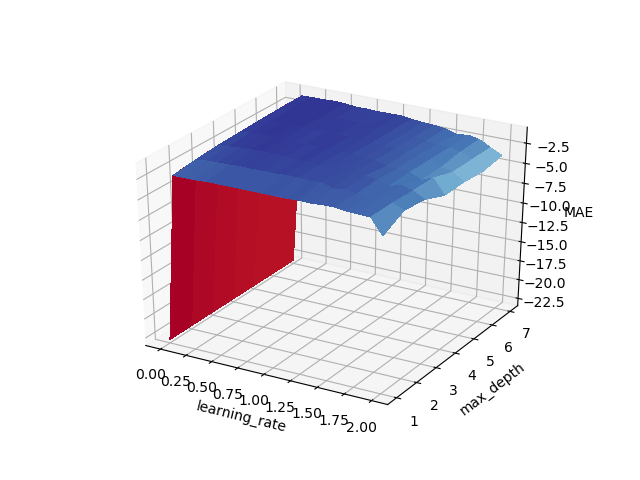

In [25]:
visualize(auto_comb2, auto_meshes, comb=2, dataset_type="reg")

### auto-mpg Comb 2 Zoom 1

In [71]:
'''
generate_zoom(winer_X, winer_y, "./np_arrays/winer_comb4.npy",
             winer_meshes, "./np_arrays_50/winer_comb4_zoom1.npy",
             zoom1=True, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="class", print_ranges=True)
'''
generate_zoom(auto_X, auto_y, "./np_arrays/auto_comb2.npy",
             auto_meshes, "./np_arrays_50/auto_comb2_zoom1.npy",
             zoom1=True, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.10526316, 0.13319012, 0.16111708, 0.18904404, 0.216971  ,
       0.24489796, 0.27282492, 0.30075188, 0.32867884, 0.3566058 ,
       0.38453276, 0.41245972, 0.44038668, 0.46831364, 0.4962406 ,
       0.52416756, 0.55209452, 0.58002148, 0.60794844, 0.6358754 ,
       0.66380236, 0.69172932, 0.71965628, 0.74758324, 0.7755102 ,
       0.80343716, 0.83136412, 0.85929108, 0.88721805, 0.91514501,
       0.94307197, 0.97099893, 0.99892589, 1.02685285, 1.05477981,
       1.08270677, 1.11063373, 1.13856069, 1.16648765, 1.19441461,
       1.22234157, 1.25026853, 1.27819549, 1.30612245, 1.33404941,
       1.36197637, 1.38990333, 1.41783029, 1.44575725, 1.47368421]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7]))


In [72]:
'''
generate_zoom(auto_X, auto_y, "./np_arrays/auto_comb2.npy",
             auto_meshes, "./np_arrays_50/auto_comb2_zoom1.npy",
             zoom1=True, save=True, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''

(array([[1.67810358, 1.60176442, 1.64053613, ..., 1.63301677, 1.5418251 ,
         1.55057685],
        [1.67810358, 1.60176442, 1.64053613, ..., 1.63301677, 1.5418251 ,
         1.55057685],
        [1.67810358, 1.60176442, 1.64053613, ..., 1.63301677, 1.5418251 ,
         1.55057685],
        ...,
        [1.12298252, 1.11454598, 1.10098744, ..., 1.61815526, 1.74862499,
         1.85472437],
        [1.12298252, 1.11454598, 1.10098744, ..., 1.61815526, 1.74862499,
         1.85472437],
        [1.08776551, 1.03765916, 1.04164111, ..., 1.68655328, 1.81285662,
         1.82820253]]),
 ((array([[0.10526316, 0.13319012, 0.16111708, ..., 1.41783029, 1.44575725,
           1.47368421],
          [0.10526316, 0.13319012, 0.16111708, ..., 1.41783029, 1.44575725,
           1.47368421],
          [0.10526316, 0.13319012, 0.16111708, ..., 1.41783029, 1.44575725,
           1.47368421],
          ...,
          [0.10526316, 0.13319012, 0.16111708, ..., 1.41783029, 1.44575725,
           1.47368

In [73]:
#winer_comb4_zoom1, winer_comb4_zoom1_meshes = np.load("./np_arrays_50/winer_comb4_zoom1.npy", allow_pickle=True)
auto_comb2_zoom1, auto_comb2_zoom1_meshes = np.load("./np_arrays_50/auto_comb2_zoom1.npy", allow_pickle=True)

In [74]:
#auto_comb1_zoom1 = 0 - auto_comb1_zoom1
auto_comb2_zoom1 = 0 - auto_comb2_zoom1

<IPython.core.display.Javascript object>


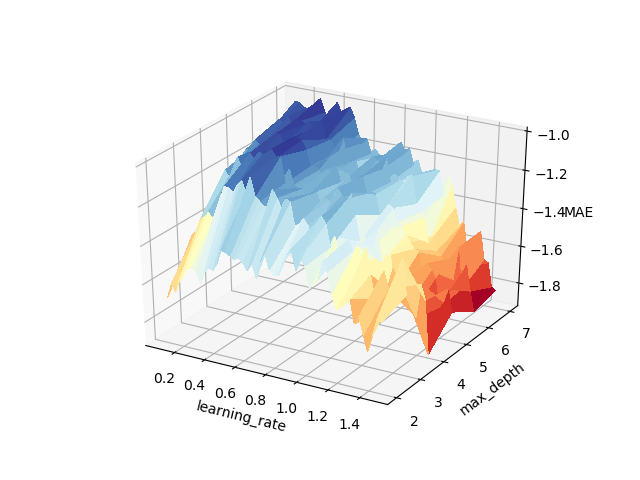

In [75]:
#visualize(winer_comb4_zoom1, winer_comb4_zoom1_meshes, comb=4, dataset_type="class")
visualize(auto_comb2_zoom1, auto_comb2_zoom1_meshes, comb=2, dataset_type="reg")

### auto-mpg Comb 2 Zoom 2

In [76]:
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb2_zoom1.npy",
             auto_comb2_zoom1_meshes, "./np_arrays_50/auto_comb2_zoom2.npy",
             zoom1=False, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.10526316, 0.12635086, 0.14743857, 0.16852627, 0.18961398,
       0.21070168, 0.23178939, 0.25287709, 0.2739648 , 0.2950525 ,
       0.3161402 , 0.33722791, 0.35831561, 0.37940332, 0.40049102,
       0.42157873, 0.44266643, 0.46375414, 0.48484184, 0.50592955,
       0.52701725, 0.54810496, 0.56919266, 0.59028037, 0.61136807,
       0.63245578, 0.65354348, 0.67463118, 0.69571889, 0.71680659,
       0.7378943 , 0.758982  , 0.78006971, 0.80115741, 0.82224512,
       0.84333282, 0.86442053, 0.88550823, 0.90659594, 0.92768364,
       0.94877135, 0.96985905, 0.99094675, 1.01203446, 1.03312216,
       1.05420987, 1.07529757, 1.09638528, 1.11747298, 1.13856069]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7]))


In [77]:
'''
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb2_zoom1.npy",
             auto_comb2_zoom1_meshes, "./np_arrays_50/auto_comb2_zoom2.npy",
             zoom1=False, save=True, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''

(array([[1.67810358, 1.64113597, 1.58555966, ..., 1.44997458, 1.26509923,
         1.35950077],
        [1.67810358, 1.64113597, 1.58555966, ..., 1.44997458, 1.26509923,
         1.35950077],
        [1.67810358, 1.64113597, 1.58555966, ..., 1.44997458, 1.26509923,
         1.35950077],
        ...,
        [1.12298252, 1.12016621, 1.07426364, ..., 1.29152977, 1.31217766,
         1.40886587],
        [1.12298252, 1.12016621, 1.07426364, ..., 1.29152977, 1.31217766,
         1.40886587],
        [1.08776551, 1.06507937, 1.0462401 , ..., 1.26050994, 1.31361537,
         1.27406597]]),
 ((array([[0.10526316, 0.12635086, 0.14743857, ..., 1.09638528, 1.11747298,
           1.13856069],
          [0.10526316, 0.12635086, 0.14743857, ..., 1.09638528, 1.11747298,
           1.13856069],
          [0.10526316, 0.12635086, 0.14743857, ..., 1.09638528, 1.11747298,
           1.13856069],
          ...,
          [0.10526316, 0.12635086, 0.14743857, ..., 1.09638528, 1.11747298,
           1.13856

In [78]:
auto_comb2_zoom2, auto_comb2_zoom2_meshes = np.load("./np_arrays_50/auto_comb2_zoom2.npy", allow_pickle=True)

In [79]:
auto_comb2_zoom2 = 0 - auto_comb2_zoom2

<IPython.core.display.Javascript object>


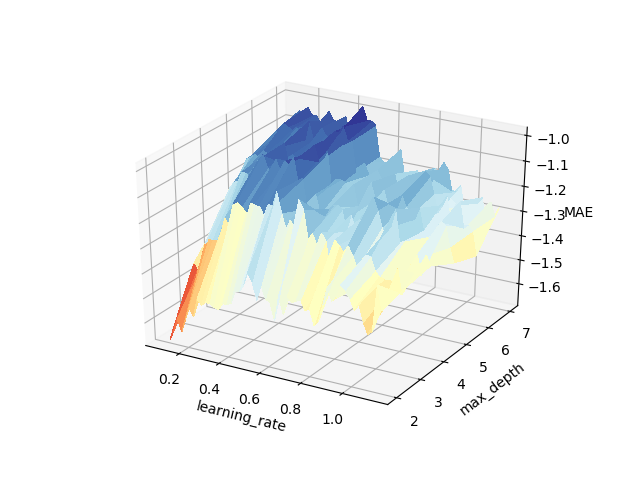

In [80]:
visualize(auto_comb2_zoom2, auto_comb2_zoom2_meshes, comb=2, dataset_type="reg")

### auto-mpg Comb 2 Zoom 3

In [81]:
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb2_zoom2.npy",
             auto_comb2_zoom2_meshes, "./np_arrays_50/auto_comb2_zoom3.npy",
             zoom1=False, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.10526316, 0.12462942, 0.14399568, 0.16336194, 0.1827282 ,
       0.20209445, 0.22146071, 0.24082697, 0.26019323, 0.27955949,
       0.29892575, 0.31829201, 0.33765827, 0.35702453, 0.37639079,
       0.39575705, 0.41512331, 0.43448957, 0.45385583, 0.47322209,
       0.49258835, 0.51195461, 0.53132086, 0.55068712, 0.57005338,
       0.58941964, 0.6087859 , 0.62815216, 0.64751842, 0.66688468,
       0.68625094, 0.7056172 , 0.72498346, 0.74434972, 0.76371598,
       0.78308224, 0.8024485 , 0.82181476, 0.84118102, 0.86054727,
       0.87991353, 0.89927979, 0.91864605, 0.93801231, 0.95737857,
       0.97674483, 0.99611109, 1.01547735, 1.03484361, 1.05420987]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7]))


In [82]:
'''
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb2_zoom2.npy",
             auto_comb2_zoom2_meshes, "./np_arrays_50/auto_comb2_zoom3.npy",
             zoom1=False, save=True, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''

(array([[1.43468608, 1.42262065, 1.37961086, ..., 1.32544332, 1.34175492,
         1.36532869],
        [1.43468608, 1.42262065, 1.37961086, ..., 1.32544332, 1.34175492,
         1.36532869],
        [1.43468608, 1.42262065, 1.37961086, ..., 1.32544332, 1.34175492,
         1.36532869],
        ...,
        [1.12298252, 1.0659739 , 1.08080672, ..., 1.28839346, 1.18241265,
         1.2061117 ],
        [1.12298252, 1.0659739 , 1.08080672, ..., 1.28839346, 1.18241265,
         1.2061117 ],
        [1.08776551, 1.06271754, 1.05620074, ..., 1.37635347, 1.30759482,
         1.25085421]]),
 ((array([[0.10526316, 0.12462942, 0.14399568, ..., 1.01547735, 1.03484361,
           1.05420987],
          [0.10526316, 0.12462942, 0.14399568, ..., 1.01547735, 1.03484361,
           1.05420987],
          [0.10526316, 0.12462942, 0.14399568, ..., 1.01547735, 1.03484361,
           1.05420987],
          ...,
          [0.10526316, 0.12462942, 0.14399568, ..., 1.01547735, 1.03484361,
           1.05420

In [83]:
auto_comb2_zoom3, auto_comb2_zoom3_meshes = np.load("./np_arrays_50/auto_comb2_zoom3.npy", allow_pickle=True)

In [84]:
auto_comb2_zoom3 = 0 - auto_comb2_zoom3

<IPython.core.display.Javascript object>


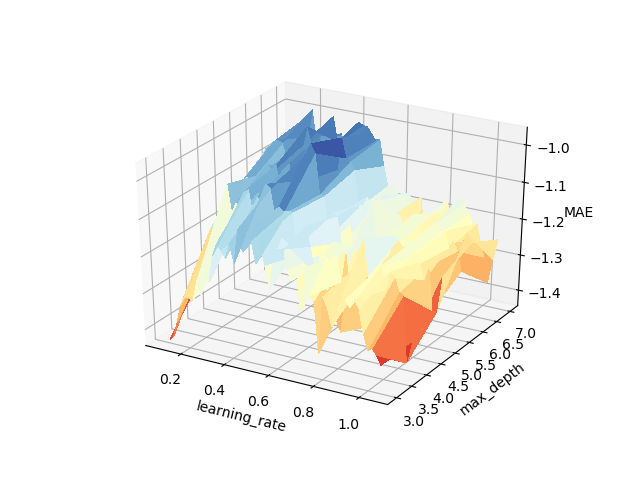

In [85]:
visualize(auto_comb2_zoom3, auto_comb2_zoom3_meshes, comb=2, dataset_type="reg")

### auto-mpg Comb 2 Zoom 4

In [86]:
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb2_zoom3.npy",
             auto_comb2_zoom3_meshes, "./np_arrays_50/auto_comb2_zoom4.npy",
             zoom1=False, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.10526316, 0.12146758, 0.137672  , 0.15387642, 0.17008084,
       0.18628526, 0.20248968, 0.21869411, 0.23489853, 0.25110295,
       0.26730737, 0.28351179, 0.29971621, 0.31592063, 0.33212505,
       0.34832947, 0.3645339 , 0.38073832, 0.39694274, 0.41314716,
       0.42935158, 0.445556  , 0.46176042, 0.47796484, 0.49416927,
       0.51037369, 0.52657811, 0.54278253, 0.55898695, 0.57519137,
       0.59139579, 0.60760021, 0.62380463, 0.64000906, 0.65621348,
       0.6724179 , 0.68862232, 0.70482674, 0.72103116, 0.73723558,
       0.75344   , 0.76964442, 0.78584885, 0.80205327, 0.81825769,
       0.83446211, 0.85066653, 0.86687095, 0.88307537, 0.89927979]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7]))


In [90]:
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb2_zoom3.npy",
             auto_comb2_zoom3_meshes, "./np_arrays_50/auto_comb2_zoom4.npy",
             zoom1=False, save=True, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)

(array([[1.43468608, 1.40568113, 1.397934  , ..., 1.25490268, 1.28186375,
         1.21383721],
        [1.43468608, 1.40568113, 1.397934  , ..., 1.25490268, 1.28186375,
         1.21383721],
        [1.43468608, 1.40568113, 1.397934  , ..., 1.25490268, 1.28186375,
         1.21383721],
        ...,
        [1.12298252, 1.07866164, 1.11405095, ..., 1.22878175, 1.17855469,
         1.16954564],
        [1.12298252, 1.07866164, 1.11405095, ..., 1.22878175, 1.17855469,
         1.16954564],
        [1.08776551, 1.08392997, 1.06662556, ..., 1.11634131, 1.21489869,
         1.17206052]]),
 ((array([[0.10526316, 0.12146758, 0.137672  , ..., 0.86687095, 0.88307537,
           0.89927979],
          [0.10526316, 0.12146758, 0.137672  , ..., 0.86687095, 0.88307537,
           0.89927979],
          [0.10526316, 0.12146758, 0.137672  , ..., 0.86687095, 0.88307537,
           0.89927979],
          ...,
          [0.10526316, 0.12146758, 0.137672  , ..., 0.86687095, 0.88307537,
           0.89927

In [91]:
auto_comb2_zoom4, auto_comb2_zoom4_meshes = np.load("./np_arrays_50/auto_comb2_zoom4.npy", allow_pickle=True)

In [92]:
auto_comb2_zoom4 = 0 - auto_comb2_zoom4

<IPython.core.display.Javascript object>


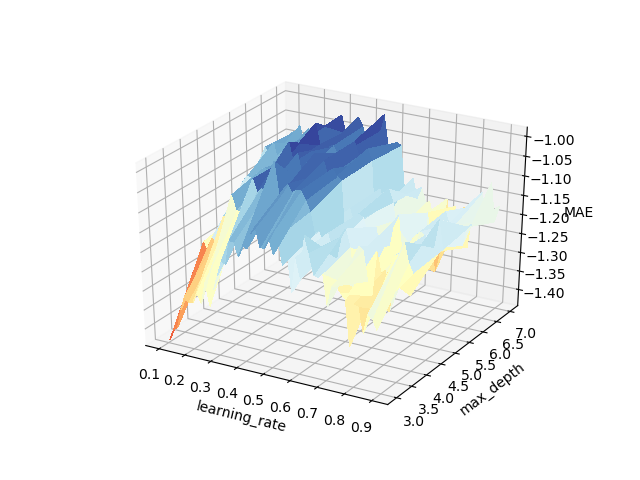

In [93]:
visualize(auto_comb2_zoom4, auto_comb2_zoom4_meshes, comb=2, dataset_type="reg")

### auto-mpg Comb 2 Zoom 5

In [94]:
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb2_zoom4.npy",
             auto_comb2_zoom4_meshes, "./np_arrays_50/auto_comb2_zoom5.npy",
             zoom1=False, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([0.10526316, 0.12113688, 0.1370106 , 0.15288431, 0.16875803,
       0.18463175, 0.20050547, 0.21637919, 0.23225291, 0.24812663,
       0.26400034, 0.27987406, 0.29574778, 0.3116215 , 0.32749522,
       0.34336894, 0.35924266, 0.37511638, 0.39099009, 0.40686381,
       0.42273753, 0.43861125, 0.45448497, 0.47035869, 0.48623241,
       0.50210612, 0.51797984, 0.53385356, 0.54972728, 0.565601  ,
       0.58147472, 0.59734844, 0.61322216, 0.62909587, 0.64496959,
       0.66084331, 0.67671703, 0.69259075, 0.70846447, 0.72433819,
       0.7402119 , 0.75608562, 0.77195934, 0.78783306, 0.80370678,
       0.8195805 , 0.83545422, 0.85132794, 0.86720165, 0.88307537]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7]))


No significant difference

## auto-mpg Comb 3

In [26]:
auto_comb3 = generate_visualization(auto_X, auto_y, auto_ranges, resolution=20, comb=3, dataset_type="reg")

In [27]:
#np.save("./np_arrays/auto_comb3.npy", auto_comb3)

In [28]:
auto_comb3 = np.load("./np_arrays/auto_comb3.npy")

In [29]:
auto_comb3 = 0 - auto_comb3

<IPython.core.display.Javascript object>


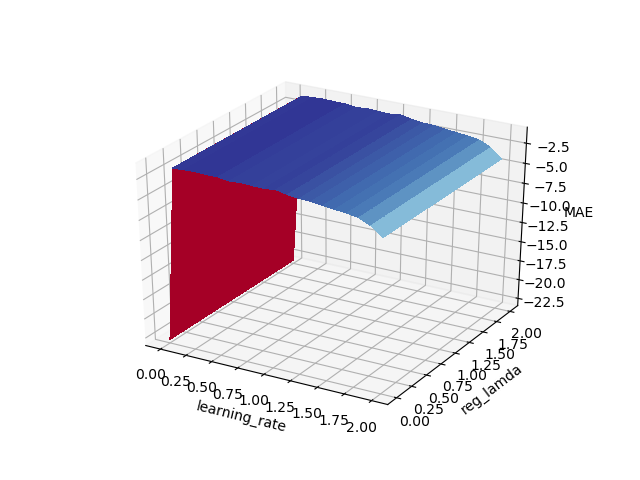

In [30]:
visualize(auto_comb3, auto_meshes, comb=3, dataset_type="reg")

## auto-mpg Comb 4

In [31]:
auto_comb4 = generate_visualization(auto_X, auto_y, auto_ranges, resolution=20, comb=4, dataset_type="reg")

In [32]:
#np.save("./np_arrays/auto_comb4.npy", auto_comb4)

In [33]:
auto_comb4 = np.load("./np_arrays/auto_comb4.npy")

In [34]:
auto_comb4 = 0 - auto_comb4

<IPython.core.display.Javascript object>


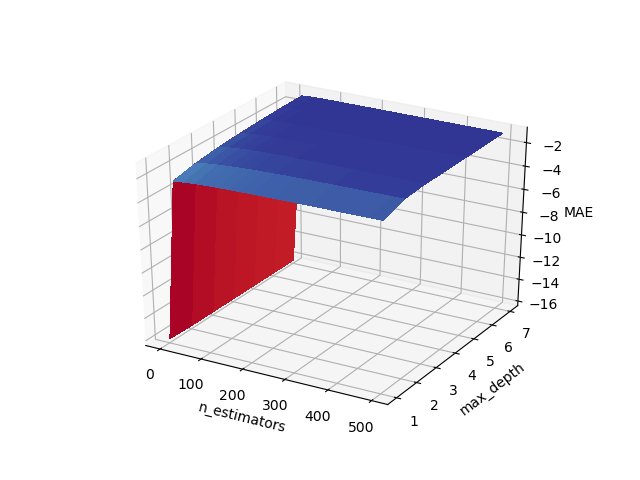

In [35]:
visualize(auto_comb4, auto_meshes, comb=4, dataset_type="reg")

### auto-mpg Comb 4 Zoom 1

In [95]:
'''
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb2_zoom3.npy",
             auto_comb2_zoom3_meshes, "./np_arrays_50/auto_comb2_zoom4.npy",
             zoom1=False, save=False, comb=2, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)
'''
generate_zoom(auto_X, auto_y, "./np_arrays/auto_comb4.npy",
             auto_meshes, "./np_arrays_50/auto_comb4_zoom1.npy",
             zoom1=True, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([ 53,  62,  71,  80,  89,  98, 107, 116, 125, 135, 144, 153, 162,
       171, 180, 189, 198, 208, 217, 226, 235, 244, 253, 262, 271, 281,
       290, 299, 308, 317, 326, 335, 344, 354, 363, 372, 381, 390, 399,
       408, 417, 427, 436, 445, 454, 463, 472, 481, 490, 500]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7]))


In [96]:
'''
generate_zoom(auto_X, auto_y, "./np_arrays/auto_comb4.npy",
             auto_meshes, "./np_arrays_50/auto_comb4_zoom1.npy",
             zoom1=True, save=True, comb=4, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=False)
'''

(array([[1.32442108, 1.29179236, 1.25572657, ..., 1.05007504, 1.04976824,
         1.04943132],
        [1.32442108, 1.29179236, 1.25572657, ..., 1.05007504, 1.04976824,
         1.04943132],
        [1.32442108, 1.29179236, 1.25572657, ..., 1.05007504, 1.04976824,
         1.04943132],
        ...,
        [1.05123149, 1.03784364, 1.03038412, ..., 1.01826522, 1.01826522,
         1.01826522],
        [1.05123149, 1.03784364, 1.03038412, ..., 1.01826522, 1.01826522,
         1.01826522],
        [1.02888196, 1.02361744, 1.01963781, ..., 1.01532644, 1.01532644,
         1.01532644]]),
 ((array([[0.        , 0.04081633, 0.08163265, ..., 1.91836735, 1.95918367,
           2.        ],
          [0.        , 0.04081633, 0.08163265, ..., 1.91836735, 1.95918367,
           2.        ],
          [0.        , 0.04081633, 0.08163265, ..., 1.91836735, 1.95918367,
           2.        ],
          ...,
          [0.        , 0.04081633, 0.08163265, ..., 1.91836735, 1.95918367,
           2.     

In [97]:
#auto_comb2_zoom4, auto_comb2_zoom4_meshes = np.load("./np_arrays_50/auto_comb2_zoom4.npy", allow_pickle=True)
auto_comb4_zoom1, auto_comb4_zoom1_meshes = np.load("./np_arrays_50/auto_comb4_zoom1.npy", allow_pickle=True)

In [98]:
auto_comb4_zoom1 = 0 - auto_comb4_zoom1

<IPython.core.display.Javascript object>


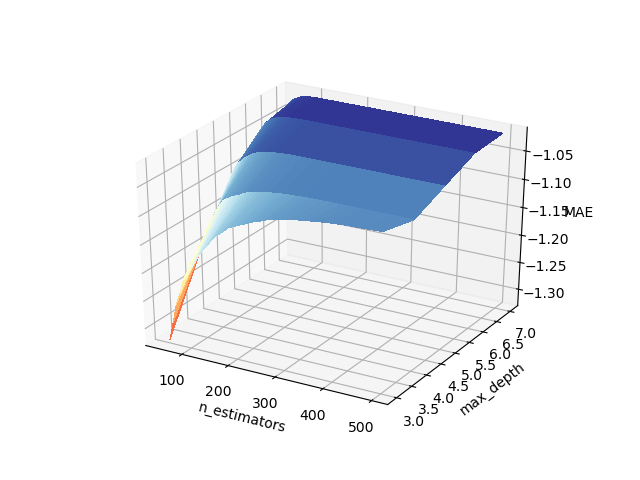

In [99]:
#visualize(auto_comb2_zoom4, auto_comb2_zoom4_meshes, comb=2, dataset_type="reg")
visualize(auto_comb4_zoom1, auto_comb4_zoom1_meshes, comb=4, dataset_type="reg")

### auto-mpg Comb 4 Zoom 2

In [100]:
generate_zoom(auto_X, auto_y, "./np_arrays_50/auto_comb4_zoom1.npy",
             auto_comb4_zoom1_meshes, "./np_arrays_50/auto_comb4_zoom2.npy",
             zoom1=False, save=False, comb=4, resolution=50, percentage=0.5, dataset_type="reg", print_ranges=True)

(array([ 53,  62,  71,  80,  89,  98, 107, 116, 125, 135, 144, 153, 162,
       171, 180, 189, 198, 208, 217, 226, 235, 244, 253, 262, 271, 281,
       290, 299, 308, 317, 326, 335, 344, 354, 363, 372, 381, 390, 399,
       408, 417, 427, 436, 445, 454, 463, 472, 481, 490, 500]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7]))


No difference

## auto-mpg Comb 5

In [36]:
auto_comb5 = generate_visualization(auto_X, auto_y, auto_ranges, resolution=20, comb=5, dataset_type="reg")

In [37]:
#np.save("./np_arrays/auto_comb5.npy", auto_comb5)

In [38]:
auto_comb5 = np.load("./np_arrays/auto_comb5.npy")

In [39]:
auto_comb5 = 0 - auto_comb5

<IPython.core.display.Javascript object>


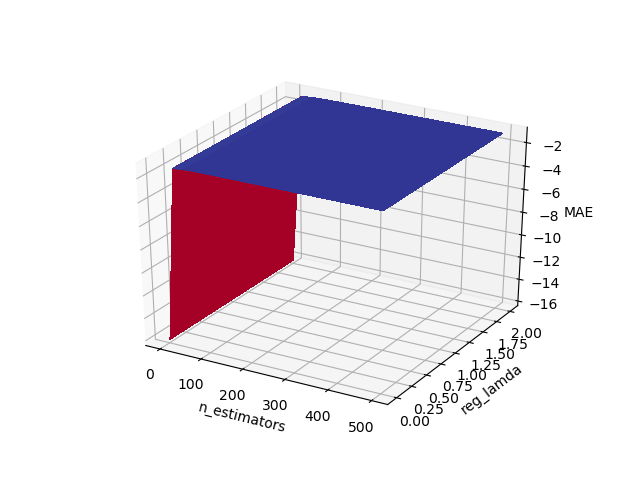

In [40]:
visualize(auto_comb5, auto_meshes, comb=5, dataset_type="reg")

## auto-mpg Comb 6

In [41]:
auto_comb6 = generate_visualization(auto_X, auto_y, auto_ranges, resolution=20, comb=6, dataset_type="reg")

In [42]:
#np.save("./np_arrays/auto_comb6.npy", auto_comb6)

In [43]:
auto_comb6 = np.load("./np_arrays/auto_comb6.npy")

In [44]:
auto_comb6 = 0- auto_comb6

<IPython.core.display.Javascript object>


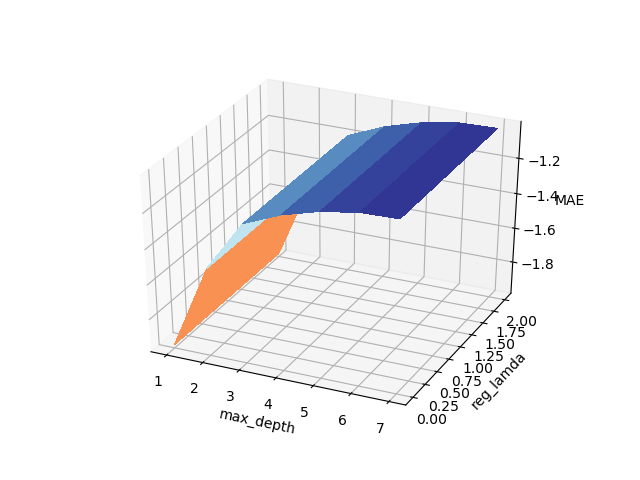

In [45]:
visualize(auto_comb6, auto_meshes, comb=6, dataset_type="reg")